In [415]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib
import matplotlib.cm as cm
import math
import re
import copy

## モデル分析の時は削除かまとめるかしたほうがよくね？リスト

* 賃貸その他が少なすぎ？
* 物件数が10に満たない路線がいくらか
* 物件数が10に満たない駅は結構
* 歩行距離遠すぎ!?だいたい郊外だし仕方ない…？
* バス変数と車変数がそもそも母数少ないよね
* 築年数も60を超えるとかなり小数になる
* 地上15階以下と16階以上ではかなり母数の差がある
* 地下もあってもB2階まで
* B26階とかないらしいよ。
* 間取りごとだと少数派が結構いる（分割すれば割と減る）
* 部屋数8はあたおからしい（42って何）

In [320]:
suumo = pd.read_csv('./data/csv/SuumoTokyoShaped20221026.csv')
suumo

カテゴリ                       建物名          経度         緯度 都道府県  市区町村  \
0        賃貸アパート                   プチ・ボヌール  139.726883  35.554230  東京都   大田区   
1        賃貸一戸建て                      荒川戸建  139.783234  35.737568  東京都   荒川区   
2        賃貸一戸建て                      荒川戸建  139.783234  35.737568  東京都   荒川区   
3       賃貸マンション              ティモーネ上野の森ノース  139.780899  35.726601  東京都   荒川区   
4        賃貸アパート   東京メトロ日比谷線 三ノ輪駅 3階建 築13年  139.795654  35.733616  東京都   荒川区   
...         ...                       ...         ...        ...  ...   ...   
156938  賃貸マンション                   メゾンスギモト  139.892426  35.720993  東京都  江戸川区   
156939  賃貸マンション                      大場ビル  139.880020  35.700130  東京都  江戸川区   
156940   賃貸一戸建て                      中澤貸家  139.902374  35.685436  東京都  江戸川区   
156941  賃貸マンション  東京メトロ副都心線 雑司が谷駅 7階建 築37年  139.716156  35.715145  東京都   豊島区   
156942   賃貸アパート                    ハイツ南大井  139.734222  35.596874  東京都   品川区   

       市区町村以下       皇居からの距離       経度(区)      緯度(区)  ...    敷金    礼金    間取り  \
0        南蒲田３  14616.934378  139.716293  35.561337  ...  14.8  14.8   42DK   
1         荒川２   6553.671842  139.783615  35.735130  ...  39.0  19.5  3SLDK   
2         荒川２   6553.671842  139.783615  35.735130  ...  39.0  19.5  3SLDK   
3       東日暮里４   5359.153627  139.783615  35.735130  ...  15.2  15.2   2LDK   
4        南千住５   6711.303856  139.783615  35.735130  ...  11.3  11.3   1LDK   
...       ...           ...         ...        ...  ...   ...   ...    ...   
156938   東小岩１  13177.918724  139.867920  35.706589  ...   8.5   8.5    2DK   
156939  西一之江２  11532.265910  139.867920  35.706589  ...   0.0   0.0   2LDK   
156940   江戸川２  13409.267611  139.867920  35.706589  ...  16.8   0.0     3K   
156941    高田１   4903.290166  139.717392  35.725555  ...   9.2   9.2    1DK   
156942   南大井５   9826.472727  139.729767  35.608822  ...   8.5   8.5      1   

        部屋数  間取り_S  間取り_L  間取り_D  間取り_K   専有面積  \
0        42      0      0      1      1  48.87   
1         3      1      1      1      1  97.95   
2         3      1      1      1      1  97.95   
3         2      0      1      1      1  52.04   
4         1      0      1      1      1  43.81   
...     ...    ...    ...    ...    ...    ...   
156938    2      0      0      1      1  40.00   
156939    2      0      1      1      1  47.25   
156940    3      0      0      0      1  52.87   
156941    1      0      0      1      1  26.04   
156942    1      0      0      0      0  28.56   

                                                      url  
0       https://suumo.jp/chintai/jnc_000046696863/?bc=...  
1       https://suumo.jp/chintai/jnc_000076009318/?bc=...  
2       https://suumo.jp/chintai/jnc_000076047600/?bc=...  
3       https://suumo.jp/chintai/jnc_000077318759/?bc=...  
4       https://suumo.jp/chintai/jnc_000077330023/?bc=...  
...                                                   ...  
156938  https://suumo.jp/chintai/jnc_000069889741/?bc=...  
156939  https://suumo.jp/chintai/jnc_000019146531/?bc=...  
156940  https://suumo.jp/chintai/jnc_000070035188/?bc=...  
156941  https://suumo.jp/chintai/jnc_000074167859/?bc=...  
156942  https://suumo.jp/chintai/jnc_000043176296/?bc=...  

[156943 rows x 35 columns]

In [62]:
rosenzu = pd.read_csv('./data/csv/スクレイピング路線図結合後データ.csv')
rosenzu.drop('Unnamed: 0',axis=1,inplace=True)

In [73]:
condition = rosenzu['路線'] == '東京メトロ丸ノ内線'
print(rosenzu.loc[20550,'路線図'])
rosenzu.loc[condition,'路線図']

https://www.navitime.co.jp/railroad/00000766/%E6%9D%B1%E4%BA%AC%E3%83%A1%E3%83%88%E3%83%AD%E4%B8%B8%E3%83%8E%E5%86%85%E7%B7%9A


20550     https://www.navitime.co.jp/railroad/00000766/%...
20551     https://www.navitime.co.jp/railroad/00000766/%...
20552     https://www.navitime.co.jp/railroad/00000766/%...
20553     https://www.navitime.co.jp/railroad/00000766/%...
20554     https://www.navitime.co.jp/railroad/00000766/%...
                                ...                        
159696    https://www.navitime.co.jp/railroad/00000766/%...
159697    https://www.navitime.co.jp/railroad/00000766/%...
159698    https://www.navitime.co.jp/railroad/00000766/%...
159699    https://www.navitime.co.jp/railroad/00000766/%...
159700    https://www.navitime.co.jp/railroad/00000766/%...
Name: 路線図, Length: 6687, dtype: object

In [80]:
rosenzu[rosenzu['駅'] == '中野新橋']

Empty DataFrame
Columns: [カテゴリ, 建物名, 経度, 緯度, 都道府県, 市区町村, 市区町村以下, 経度(区), 緯度(区), 路線, 駅, 経度(駅), 緯度(駅), 歩, バス, 車, 築年数, 地上, 地下, 階数, 階, 賃料, 管理費, 敷金, 礼金, 間取り, 専有面積, url, 路線図, 駅番号]
Index: []

[0 rows x 30 columns]

In [71]:
sorted(rosenzu['路線'].unique())

['つくばエクスプレス',
 'りんかい線',
 '京急本線',
 '京急空港線',
 '京成押上線',
 '京成本線',
 '京成金町線',
 '京王井の頭線',
 '京王新線',
 '京王線',
 '北総線',
 '埼玉高速鉄道',
 '小田急線',
 '新交通ゆりかもめ',
 '日暮里・舎人ライナー',
 '東京メトロ丸ノ内線',
 '東京メトロ副都心線',
 '東京メトロ千代田線',
 '東京メトロ半蔵門線',
 '東京メトロ南北線',
 '東京メトロ日比谷線',
 '東京メトロ有楽町線',
 '東京メトロ東西線',
 '東京メトロ銀座線',
 '東京モノレール',
 '東北新幹線',
 '東急世田谷線',
 '東急多摩川線',
 '東急大井町線',
 '東急東横線',
 '東急池上線',
 '東急田園都市線',
 '東急目黒線',
 '東武亀戸線',
 '東武伊勢崎線',
 '東武大師線',
 '東武東上線',
 '東海道新幹線',
 '湘南新宿ライン宇須',
 '西武新宿線',
 '西武有楽町線',
 '西武池袋線',
 '西武豊島線',
 '都営三田線',
 '都営大江戸線',
 '都営新宿線',
 '都営浅草線',
 '都電荒川線',
 'ＪＲ中央線',
 'ＪＲ京浜東北線',
 'ＪＲ京葉線',
 'ＪＲ埼京線',
 'ＪＲ宇都宮線',
 'ＪＲ山手線',
 'ＪＲ常磐線',
 'ＪＲ東海道本線',
 'ＪＲ横須賀線',
 'ＪＲ総武線']

In [55]:
station[station['路線'] == 'ＪＲ山手線'].sort_values('駅番号')['経度']

208    139.729462
123    139.722870
165    139.715363
108    139.709900
14     139.705826
59     139.705307
262    139.700043
23     139.703568
169    139.699234
126    139.707504
404    139.705582
33     139.703873
284    139.727066
260    139.734818
371    139.747482
385    139.763168
306    139.768387
161    139.771027
329    139.779144
47     139.779266
147    139.775314
61     139.775650
153    139.770981
4      139.767197
78     139.763474
69     139.760574
140    139.755981
186    139.747833
481    139.739700
43     139.734344
209    139.729462
Name: 経度, dtype: float64

In [4]:
station_all = pd.read_csv('./data/csv/station_all.csv')

In [5]:
station_all

路線  駅番号       駅            住所          経度         緯度
0    つくばエクスプレス  1.0     秋葉原  東京都千代田区神田平河町  139.775650  35.698036
1    つくばエクスプレス  2.0    新御徒町  東京都台東区元浅草1丁目  139.783875  35.708111
2    つくばエクスプレス  3.0      浅草   東京都台東区駒形2丁目  139.795456  35.706589
3    つくばエクスプレス  4.0     南千住  東京都荒川区南千住4丁目  139.802734  35.734295
4    つくばエクスプレス  5.0     北千住    東京都足立区千住旭町  139.807159  35.748875
..         ...  ...     ...           ...         ...        ...
917        NaN  NaN     鐘ケ淵   東京都墨田区墨田5丁目  139.820343  35.738304
918        NaN  NaN    大塚駅前  東京都豊島区南大塚3丁目  139.727066  35.729118
919        NaN  NaN    町屋駅前   東京都荒川区荒川7丁目  139.782242  35.741608
920        NaN  NaN  都電雑司ケ谷  東京都豊島区南池袋4丁目  139.717072  35.722450
921        NaN  NaN  西ケ原四丁目   東京都北区西ケ原4丁目  139.735107  35.743290

[922 rows x 6 columns]

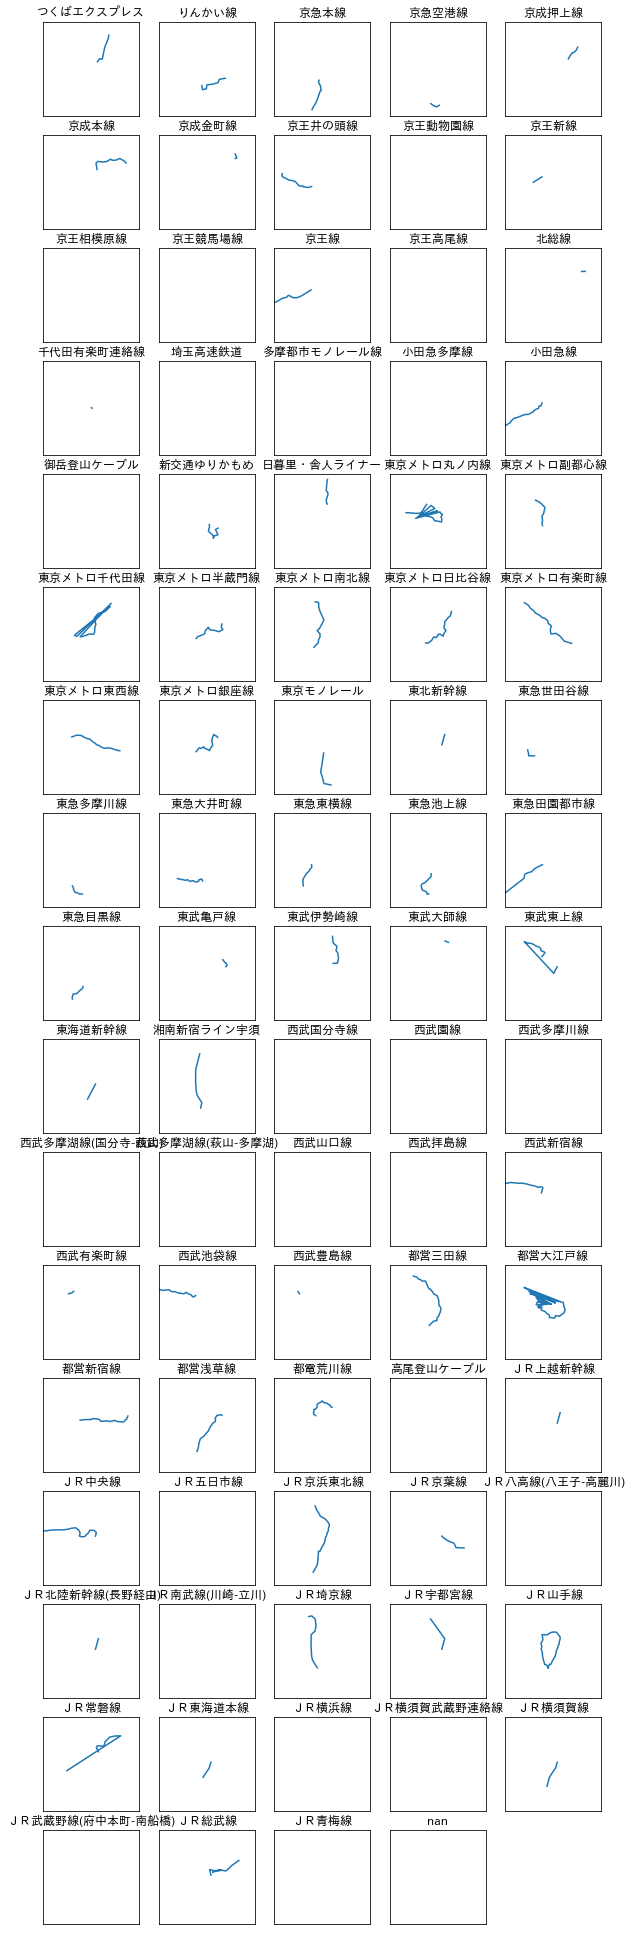

In [52]:
# 路線ごとに描き出すぞ
fig = plt.figure(figsize=(10,35))

line_all = station_all['路線'].unique()
num_line = line_all.shape[0]
num_rows = int(num_line/num_cols)+1
num_cols = 5

for num, line in enumerate(line_all):
    condition = station_all['路線'] == line
    ax = fig.add_subplot(num_rows,num_cols,num+1)
    plt.title(line)
    ax.plot(station_all.loc[condition,'経度'],station_all.loc[condition,'緯度'])
    plt.xlim(139.55,139.95)
    plt.ylim(35.52,35.83)
    plt.xticks([])
    plt.yticks([])

plt.show()

In [56]:
# 都営大江戸線、メトロ丸の内、メトロ千代田、東武東上線、JR常磐線がバグ
condition = station_all['路線'] == '東京メトロ丸ノ内線'
station_all[condition]

路線   駅番号       駅               住所          経度         緯度
202  東京メトロ丸ノ内線   1.0      池袋     東京都豊島区西池袋3丁目  139.703873  35.729156
203  東京メトロ丸ノ内線   1.0    中野坂上      東京都中野区中央2丁目  139.679337  35.699482
204  東京メトロ丸ノ内線   2.0    中野新橋     東京都中野区弥生町2丁目  139.673935  35.691502
205  東京メトロ丸ノ内線   2.0     新大塚     東京都豊島区東池袋5丁目  139.723068  35.725929
206  東京メトロ丸ノ内線   3.0     茗荷谷     東京都文京区小日向4丁目  139.738403  35.715515
207  東京メトロ丸ノ内線   3.0  中野富士見町     東京都中野区弥生町5丁目  139.666214  35.688061
208  東京メトロ丸ノ内線   4.0     後楽園      東京都文京区春日1丁目  139.749435  35.708050
209  東京メトロ丸ノ内線   4.0     方南町      東京都杉並区方南2丁目  139.658249  35.683403
210  東京メトロ丸ノ内線   5.0   本郷三丁目      東京都文京区本郷2丁目  139.759766  35.704502
211  東京メトロ丸ノ内線   6.0    御茶ノ水  東京都千代田区神田駿河台2丁目  139.762009  35.700069
212  東京メトロ丸ノ内線   7.0     淡路町  東京都千代田区神田須田町1丁目  139.769836  35.696224
213  東京メトロ丸ノ内線   8.0     大手町    東京都千代田区大手町1丁目  139.763931  35.688068
214  東京メトロ丸ノ内線   9.0      東京    東京都千代田区丸の内1丁目  139.767197  35.681561
215  東京メトロ丸ノ内線  10.0      銀座      東京都中央区銀座4丁目  139.766251  35.671169
216  東京メトロ丸ノ内線  11.0     霞ケ関    東京都千代田区霞が関1丁目  139.752563  35.673943
217  東京メトロ丸ノ内線  12.0  国会議事堂前    東京都千代田区永田町2丁目  139.741226  35.675049
218  東京メトロ丸ノ内線  13.0    赤坂見附       東京都港区赤坂3丁目  139.737137  35.675640
219  東京メトロ丸ノ内線  14.0     四ツ谷      東京都新宿区四谷1丁目  139.728806  35.685905
220  東京メトロ丸ノ内線  15.0   四谷三丁目      東京都新宿区四谷3丁目  139.720749  35.688019
221  東京メトロ丸ノ内線  16.0   新宿御苑前      東京都新宿区新宿1丁目  139.712250  35.689556
222  東京メトロ丸ノ内線  17.0   新宿三丁目      東京都新宿区新宿3丁目  139.703568  35.691227
223  東京メトロ丸ノ内線  18.0      新宿      東京都新宿区新宿3丁目  139.703568  35.691227
224  東京メトロ丸ノ内線  19.0     西新宿     東京都新宿区西新宿8丁目  139.692459  35.695778
225  東京メトロ丸ノ内線  20.0    中野坂上      東京都中野区中央2丁目  139.679337  35.699482
226  東京メトロ丸ノ内線  21.0     新中野      東京都中野区中央4丁目  139.669220  35.700188
227  東京メトロ丸ノ内線  22.0    東高円寺    東京都杉並区高円寺南1丁目  139.658417  35.699722
228  東京メトロ丸ノ内線  23.0    新高円寺    東京都杉並区高円寺南2丁目  139.651337  35.700199
229  東京メトロ丸ノ内線  24.0   南阿佐ケ谷    東京都杉並区阿佐谷南1丁目  139.639847  35.701118
230  東京メトロ丸ノ内線  25.0      荻窪      東京都杉並区荻窪5丁目  139.618683  35.702209

In [364]:
motorosenzu = pd.read_csv('./data/csv/元路線図.csv')
motorosenzu.drop('Unnamed: 0', axis=1, inplace=True)
motorosenzu

路線         駅  駅番号
0         東海道新幹線       東京駅    1
1         東海道新幹線       品川駅    2
2         東海道新幹線      新横浜駅    3
3         東海道新幹線      小田原駅    4
4         東海道新幹線       熱海駅    5
...          ...       ...  ...
1539  日暮里・舎人ライナー  見沼代親水公園駅   13
1540    御岳登山ケーブル       滝本駅    1
1541    御岳登山ケーブル      御岳山駅    2
1542    高尾登山ケーブル       清滝駅    1
1543    高尾登山ケーブル      高尾山駅    2

[1544 rows x 3 columns]

In [89]:
# 都営大江戸線は2種類存在する => 分岐させた方がよさげ
motorosenzu[motorosenzu['路線'] == '都営大江戸線']

路線        駅  駅番号
1215  都営大江戸線     都庁前駅    1
1216  都営大江戸線    新宿西口駅    2
1217  都営大江戸線     東新宿駅    3
1218  都営大江戸線    若松河田駅    4
1219  都営大江戸線    牛込柳町駅    5
1220  都営大江戸線   牛込神楽坂駅    6
1221  都営大江戸線     飯田橋駅    7
1222  都営大江戸線      春日駅    8
1223  都営大江戸線   本郷三丁目駅    9
1224  都営大江戸線   上野御徒町駅   10
1225  都営大江戸線    新御徒町駅   11
1226  都営大江戸線      蔵前駅   12
1227  都営大江戸線      両国駅   13
1228  都営大江戸線      森下駅   14
1229  都営大江戸線    清澄白河駅   15
1230  都営大江戸線    門前仲町駅   16
1231  都営大江戸線      月島駅   17
1232  都営大江戸線     勝どき駅   18
1233  都営大江戸線    築地市場駅   19
1234  都営大江戸線      汐留駅   20
1235  都営大江戸線      大門駅   21
1236  都営大江戸線     赤羽橋駅   22
1237  都営大江戸線    麻布十番駅   23
1238  都営大江戸線     六本木駅   24
1239  都営大江戸線   青山一丁目駅   25
1240  都営大江戸線   国立競技場駅   26
1241  都営大江戸線     代々木駅   27
1242  都営大江戸線      新宿駅   28
1243  都営大江戸線     都庁前駅   29
1494  都営大江戸線     都庁前駅    1
1495  都営大江戸線  西新宿五丁目駅    2
1496  都営大江戸線    中野坂上駅    3
1497  都営大江戸線     東中野駅    4
1498  都営大江戸線      中井駅    5
1499  都営大江戸線   落合南長崎駅    6
1500  都営大江戸線    新江古田駅    7
1501  都営大江戸線      練馬駅    8
1502  都営大江戸線     豊島園駅    9
1503  都営大江戸線   練馬春日町駅   10
1504  都営大江戸線     光が丘駅   11

In [88]:
# 分岐ルートが存在する -> 分けたほうがよさげ
motorosenzu[motorosenzu['路線'] == '東京メトロ丸ノ内線']

路線        駅  駅番号
918  東京メトロ丸ノ内線      池袋駅    1
919  東京メトロ丸ノ内線     新大塚駅    2
920  東京メトロ丸ノ内線     茗荷谷駅    3
921  東京メトロ丸ノ内線     後楽園駅    4
922  東京メトロ丸ノ内線   本郷三丁目駅    5
923  東京メトロ丸ノ内線    御茶ノ水駅    6
924  東京メトロ丸ノ内線     淡路町駅    7
925  東京メトロ丸ノ内線     大手町駅    8
926  東京メトロ丸ノ内線      東京駅    9
927  東京メトロ丸ノ内線      銀座駅   10
928  東京メトロ丸ノ内線     霞ケ関駅   11
929  東京メトロ丸ノ内線  国会議事堂前駅   12
930  東京メトロ丸ノ内線    赤坂見附駅   13
931  東京メトロ丸ノ内線     四ツ谷駅   14
932  東京メトロ丸ノ内線   四谷三丁目駅   15
933  東京メトロ丸ノ内線   新宿御苑前駅   16
934  東京メトロ丸ノ内線   新宿三丁目駅   17
935  東京メトロ丸ノ内線      新宿駅   18
936  東京メトロ丸ノ内線     西新宿駅   19
937  東京メトロ丸ノ内線    中野坂上駅   20
938  東京メトロ丸ノ内線     新中野駅   21
939  東京メトロ丸ノ内線    東高円寺駅   22
940  東京メトロ丸ノ内線    新高円寺駅   23
941  東京メトロ丸ノ内線   南阿佐ケ谷駅   24
942  東京メトロ丸ノ内線      荻窪駅   25
943  東京メトロ丸ノ内線    中野坂上駅    1
944  東京メトロ丸ノ内線    中野新橋駅    2
945  東京メトロ丸ノ内線  中野富士見町駅    3
946  東京メトロ丸ノ内線     方南町駅    4

In [90]:
# 最後のほうの構築がバグ -> 表を作り直した方が良い
motorosenzu[motorosenzu['路線'] == '東京メトロ千代田線']

路線        駅  駅番号
966  東京メトロ千代田線   代々木上原駅    1
967  東京メトロ千代田線   代々木公園駅    2
968  東京メトロ千代田線   明治神宮前駅    3
969  東京メトロ千代田線     表参道駅    4
970  東京メトロ千代田線     乃木坂駅    5
971  東京メトロ千代田線      赤坂駅    6
972  東京メトロ千代田線  国会議事堂前駅    7
973  東京メトロ千代田線     霞ケ関駅    8
974  東京メトロ千代田線     日比谷駅    9
975  東京メトロ千代田線    二重橋前駅   10
976  東京メトロ千代田線     大手町駅   11
977  東京メトロ千代田線   新御茶ノ水駅   12
978  東京メトロ千代田線      湯島駅   13
979  東京メトロ千代田線      根津駅   14
980  東京メトロ千代田線     千駄木駅   15
981  東京メトロ千代田線    西日暮里駅   16
982  東京メトロ千代田線      町屋駅   17
983  東京メトロ千代田線     北千住駅   18
984  東京メトロ千代田線      綾瀬駅   19
985  東京メトロ千代田線      綾瀬駅    1
986  東京メトロ千代田線     北綾瀬駅    2

In [91]:
# くっつけるときにバグったか？
motorosenzu[motorosenzu['路線'] == '東武東上線']

路線       駅  駅番号
1411  東武東上線     池袋駅    1
1412  東武東上線    北池袋駅    2
1413  東武東上線    下板橋駅    3
1414  東武東上線     大山駅    4
1415  東武東上線    中板橋駅    5
1416  東武東上線   ときわ台駅    6
1417  東武東上線    上板橋駅    7
1418  東武東上線   東武練馬駅    8
1419  東武東上線    下赤塚駅    9
1420  東武東上線     成増駅   10
1421  東武東上線    和光市駅   11
1422  東武東上線     朝霞駅   12
1423  東武東上線    朝霞台駅   13
1424  東武東上線     志木駅   14
1425  東武東上線    柳瀬川駅   15
1426  東武東上線   みずほ台駅   16
1427  東武東上線     鶴瀬駅   17
1428  東武東上線   ふじみ野駅   18
1429  東武東上線    上福岡駅   19
1430  東武東上線    新河岸駅   20
1431  東武東上線     川越駅   21
1432  東武東上線    川越市駅   22
1433  東武東上線    霞ケ関駅   23
1434  東武東上線    鶴ケ島駅   24
1435  東武東上線     若葉駅   25
1436  東武東上線     坂戸駅   26
1437  東武東上線    北坂戸駅   27
1438  東武東上線     高坂駅   28
1439  東武東上線    東松山駅   29
1440  東武東上線   森林公園駅   30
1441  東武東上線   つきのわ駅   31
1442  東武東上線   武蔵嵐山駅   32
1443  東武東上線    小川町駅   33
1444  東武東上線   東武竹沢駅   34
1445  東武東上線  みなみ寄居駅   35
1446  東武東上線     男衾駅   36
1447  東武東上線     鉢形駅   37
1448  東武東上線     玉淀駅   38
1449  東武東上線     寄居駅   39

In [107]:
# 他県に存在する同じ地名 => 表から削除
condition = station_all['路線'] == '東武東上線'
station_all[condition]

路線   駅番号     駅               住所          経度         緯度
483  東武東上線   1.0    池袋     東京都豊島区西池袋3丁目  139.703873  35.729156
484  東武東上線   2.0   北池袋    東京都豊島区池袋本町1丁目  139.714142  35.739292
485  東武東上線   3.0   下板橋    東京都豊島区池袋本町4丁目  139.715836  35.743126
486  東武東上線   4.0    大山        東京都板橋区大山町  139.699738  35.748611
487  東武東上線   5.0   中板橋        東京都板橋区中板橋  139.698044  35.755951
488  東武東上線   6.0  ときわ台     東京都板橋区常盤台1丁目  139.692337  35.760250
489  東武東上線   7.0   上板橋     東京都板橋区常盤台4丁目  139.679443  35.763645
490  東武東上線   8.0  東武練馬      東京都板橋区徳丸2丁目  139.660950  35.772018
491  東武東上線   9.0   下赤塚      東京都板橋区赤塚2丁目  139.640518  35.773922
492  東武東上線  10.0    成増      東京都板橋区成増2丁目  139.630417  35.778057
493  東武東上線  23.0   霞ケ関    東京都千代田区霞が関1丁目  139.752563  35.673943
494  東武東上線  33.0   小川町  東京都千代田区神田淡路町1丁目  139.767029  35.695759

In [103]:
# 常磐線さん！？
motorosenzu[motorosenzu['路線'] == 'ＪＲ常磐線']

路線     駅  駅番号
178  ＪＲ常磐線   上野駅    1
179  ＪＲ常磐線  日暮里駅    2
180  ＪＲ常磐線  三河島駅    3
181  ＪＲ常磐線  南千住駅    4
182  ＪＲ常磐線  北千住駅    5
..     ...   ...  ...
254  ＪＲ常磐線   山下駅   77
255  ＪＲ常磐線  浜吉田駅   78
256  ＪＲ常磐線   亘理駅   79
257  ＪＲ常磐線   逢隈駅   80
258  ＪＲ常磐線   岩沼駅   81

[81 rows x 3 columns]

In [105]:
# 都内じゃないけど同じ地名で反応する -> 表から削除
condition = station_all['路線'] == 'ＪＲ常磐線'
station_all[condition]

路線   駅番号    駅             住所          経度         緯度
842  ＪＲ常磐線   1.0   上野    東京都台東区上野7丁目  139.779266  35.715878
843  ＪＲ常磐線   2.0  日暮里  東京都荒川区西日暮里2丁目  139.771027  35.730396
844  ＪＲ常磐線   3.0  三河島  東京都荒川区西日暮里1丁目  139.774368  35.735165
845  ＪＲ常磐線   4.0  南千住   東京都荒川区南千住4丁目  139.802734  35.734295
846  ＪＲ常磐線   5.0  北千住     東京都足立区千住旭町  139.807159  35.748875
847  ＪＲ常磐線   6.0   綾瀬    東京都足立区綾瀬3丁目  139.826447  35.764004
848  ＪＲ常磐線   7.0   亀有    東京都葛飾区亀有5丁目  139.847137  35.767639
849  ＪＲ常磐線   8.0   金町    東京都葛飾区金町6丁目  139.872391  35.768391
850  ＪＲ常磐線  77.0   山下  東京都世田谷区豪徳寺1丁目  139.648178  35.653641

In [102]:
condition = motorosenzu['路線'].str.contains('ＪＲ')
motorosenzu.loc[condition,'路線'].unique()

array(['ＪＲ横須賀線', 'ＪＲ横浜線', 'ＪＲ京浜東北線', 'ＪＲ京葉線', 'ＪＲ五日市線', 'ＪＲ埼京線', 'ＪＲ山手線',
       'ＪＲ上越新幹線', 'ＪＲ常磐線', 'ＪＲ青梅線', 'ＪＲ総武線', 'ＪＲ中央線', 'ＪＲ北陸新幹線(長野経由)',
       'ＪＲ東海道本線', 'ＪＲ宇都宮線', 'ＪＲ南武線(川崎-立川)', 'ＪＲ八高線(八王子-高麗川)',
       'ＪＲ武蔵野線(府中本町-南船橋)', 'ＪＲ横須賀武蔵野連絡線'], dtype=object)

In [96]:
station_coordinates = pd.read_csv('./data/csv/station_coordinates.csv')
station_coordinates

駅             住所          経度         緯度
0       東京  東京都千代田区丸の内1丁目  139.767197  35.681561
1       渋谷    東京都渋谷区渋谷2丁目  139.705826  35.659611
2       新宿    東京都新宿区新宿3丁目  139.703568  35.691227
3       池袋   東京都豊島区西池袋3丁目  139.703873  35.729156
4       品川     東京都港区高輪3丁目  139.734344  35.631805
..     ...            ...         ...        ...
645  町屋二丁目    東京都荒川区荒川6丁目  139.777557  35.742123
646    程久保   東京都日野市程久保8丁目  139.406967  35.653271
647    二俣尾   東京都青梅市二俣尾4丁目  139.218353  35.808388
648    飛鳥山    東京都北区滝野川1丁目  139.735580  35.747856
649     清滝     東京都八王子市高尾町  139.257980  35.633018

[650 rows x 4 columns]

In [114]:
feature_name = [
    'カテゴリ',
    '建物名',
    '経度',
    '緯度',
    '都道府県',
    '市区町村',
    '市区町村以下',
    '皇居からの距離',
    '経度(区)',
    '緯度(区)',
    '路線',
    '駅',
    '経度(駅)',
    '緯度(駅)',
    '最寄駅からの距離', 
    '歩', 
    'バス', 
    '車', 
    '築年数', 
    '地上', 
    '地下', 
    '階数', 
    '階', 
    '賃料', 
    '管理費', 
    '敷金', 
    '礼金', 
    '間取り', 
    '部屋数', 
    '間取り_S', 
    '間取り_L', 
    '間取り_D', 
    '間取り_K', 
    '専有面積', 
    'url'
]

In [321]:
suumo.columns

Index(['カテゴリ', '建物名', '経度', '緯度', '都道府県', '市区町村', '市区町村以下', '皇居からの距離', '経度(区)',
       '緯度(区)', '路線', '駅', '経度(駅)', '緯度(駅)', '最寄駅からの距離', '歩', 'バス', '車', '築年数',
       '地上', '地下', '階数', '階', '賃料', '管理費', '敷金', '礼金', '間取り', '部屋数', '間取り_S',
       '間取り_L', '間取り_D', '間取り_K', '専有面積', 'url'],
      dtype='object')

# 可視化

## 相関

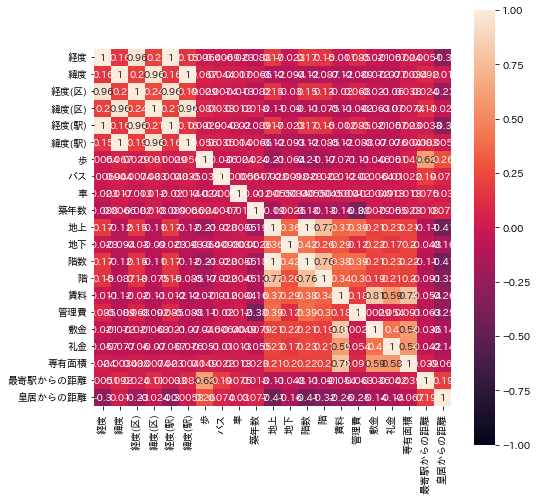

In [145]:
# 相関が高いのは
#（階：地上：地下：階数）
# (賃料：敷金：礼金：専有面積)
# (管理費：築年数)不
plt.figure(figsize=(8,8))
sns.heatmap(suumo.corr(),annot=True, vmax=1,vmin=-1, square=True)
plt.show()

In [146]:
suumo.corr()['賃料']

経度         -0.011320
緯度         -0.124035
経度(区)      -0.019845
緯度(区)      -0.112953
経度(駅)      -0.012087
緯度(駅)      -0.122015
歩          -0.070862
バス         -0.011691
車          -0.000403
築年数        -0.160251
地上          0.366811
地下          0.293706
階数          0.376052
階           0.341567
賃料          1.000000
管理費         0.184191
敷金          0.808201
礼金          0.591957
専有面積        0.779260
最寄駅からの距離   -0.053727
皇居からの距離    -0.264876
Name: 賃料, dtype: float64

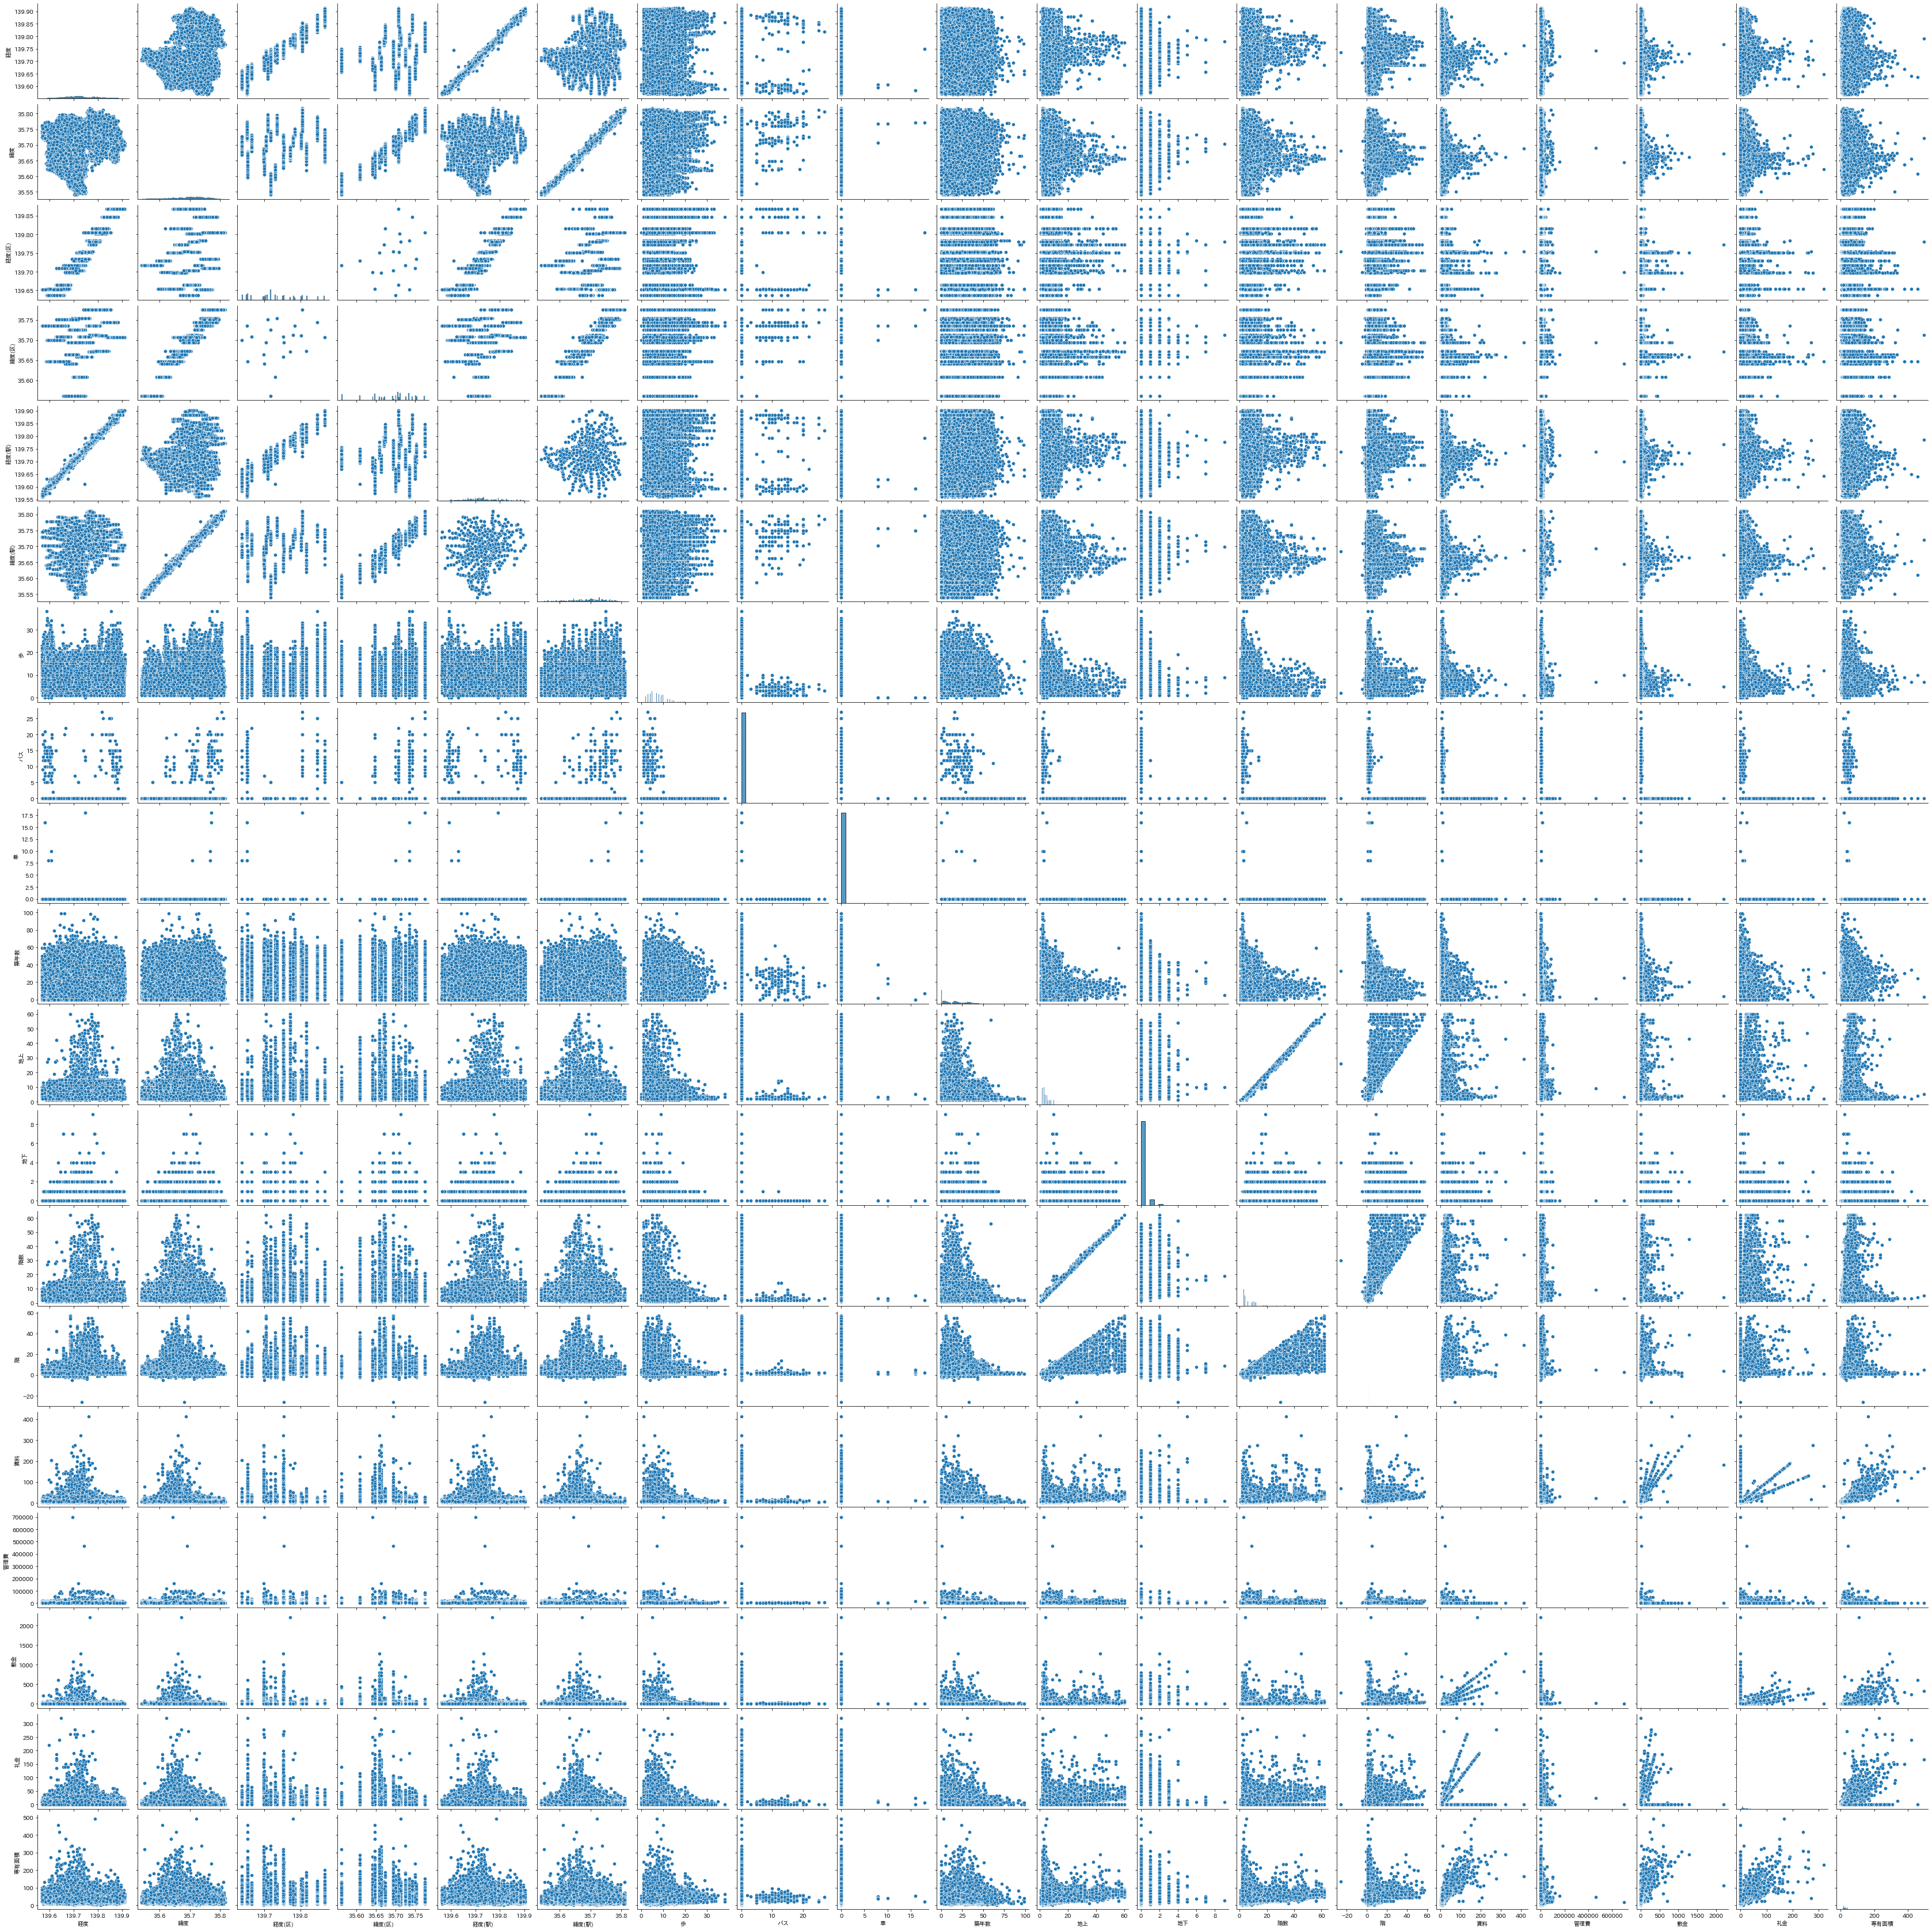

In [7]:
sns.pairplot(data=suumo)

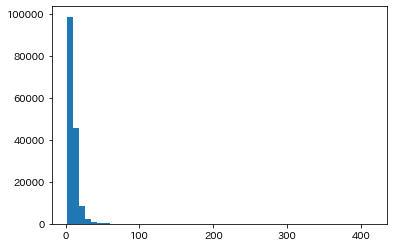

In [352]:
plt.hist(suumo['賃料'], bins=50)
plt.show()

In [360]:
condition = suumo['賃料'] >= 100
suumo[condition].sort_values('賃料',ascending=False)['賃料']

136800    413.96
96646     322.00
145167    277.00
141495    277.00
11597     270.00
           ...  
132374    100.00
91429     100.00
134351    100.00
139936    100.00
132375    100.00
Name: 賃料, Length: 181, dtype: float64

In [363]:
suumo.loc[96646,'url']

'https://suumo.jp/chintai/jnc_000059443019/?bc=100239679850'

## カテゴリ

In [29]:
# カテゴリは6種類
print(suumo['カテゴリ'].unique())

['賃貸アパート' '賃貸一戸建て' '賃貸マンション' '賃貸テラス・タウンハウス' '賃貸その他']


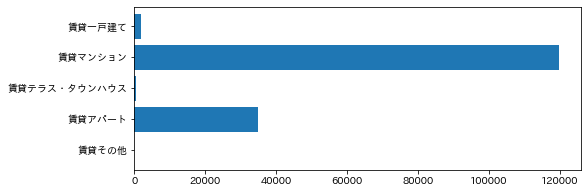

In [139]:
# 10中89はマンションとアパート
feature = 'カテゴリ'

height = suumo[feature].unique().shape[0] * (3 / 5)
width = 8
counts = suumo.groupby(feature, as_index=False).count()[[feature,'建物名']]
plt.figure(figsize=(8,height))
plt.barh(counts[feature],counts['建物名'])
plt.show()

In [277]:
# 少ない奴はマジで少ない
feature = 'カテゴリ'
counts = suumo.groupby(feature, as_index=False).count()[[feature,'建物名']]
counts.rename(columns = {'建物名':'count'}, inplace=True)
counts['ratio'] = counts['count'] / suumo.shape[0]
counts.sort_values('count')[:20]

カテゴリ   count     ratio
0         賃貸その他      43  0.000274
2  賃貸テラス・タウンハウス     504  0.003211
4        賃貸一戸建て    1859  0.011845
1        賃貸アパート   34758  0.221469
3       賃貸マンション  119779  0.763201

0    0.000274
1    0.221469
2    0.003211
3    0.763201
4    0.011845
dtype: float64

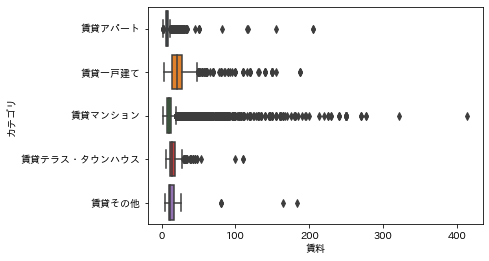

In [39]:
# カテゴリと賃料の関係
# スケールがでかすぎる
sns.boxplot(data=suumo, x='賃料', y='カテゴリ')
plt.show()

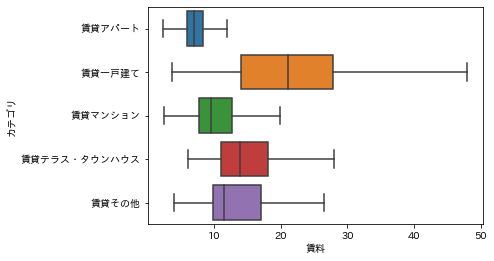

In [41]:
# 外れ値を外す
# 賃貸1戸建ては結構幅がある
# マンションは安めの層がメインだが小数のぶっ壊れが存在する
sns.boxplot(data=suumo, x='賃料', y='カテゴリ', sym='')
plt.show()

## 市区町村

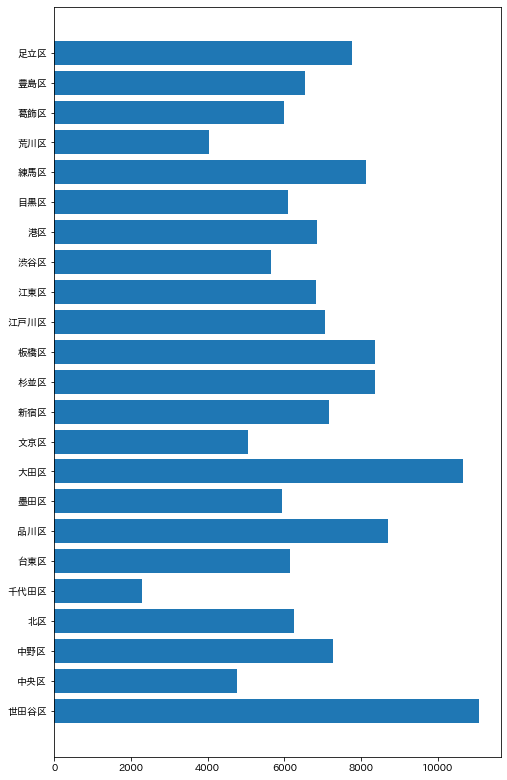

In [140]:
# 特別少ない地域はない
feature = '市区町村'

height = suumo[feature].unique().shape[0] * (3 / 5)
width = 8
counts = suumo.groupby(feature, as_index=False).count()[[feature,'建物名']]
plt.figure(figsize=(8,height))
plt.barh(counts[feature],counts['建物名'])
plt.show()

In [278]:
# 少ない奴はマジで少ない
feature = '市区町村'
counts = suumo.groupby(feature, as_index=False).count()[[feature,'建物名']]
counts.rename(columns = {'建物名':'count'}, inplace=True)
counts['ratio'] = counts['count'] / suumo.shape[0]
counts.sort_values('count')[:20]

市区町村  count     ratio
4   千代田区   2279  0.014521
19   荒川区   4048  0.025793
1    中央区   4764  0.030355
9    文京区   5046  0.032152
15   渋谷区   5656  0.036039
7    墨田区   5934  0.037810
20   葛飾区   5996  0.038205
17   目黒区   6089  0.038798
5    台東区   6144  0.039148
3     北区   6257  0.039868
21   豊島区   6533  0.041627
14   江東区   6822  0.043468
16    港区   6855  0.043678
13  江戸川区   7063  0.045004
10   新宿区   7161  0.045628
2    中野区   7261  0.046265
22   足立区   7753  0.049400
18   練馬区   8119  0.051732
11   杉並区   8354  0.053230
12   板橋区   8360  0.053268

In [298]:
# 順番調整
def order_mean(group, by, index, asc):
    sort_describe = suumo.groupby(group).describe()[by].sort_values(index,ascending=asc)
    order = sort_describe.index
    return order

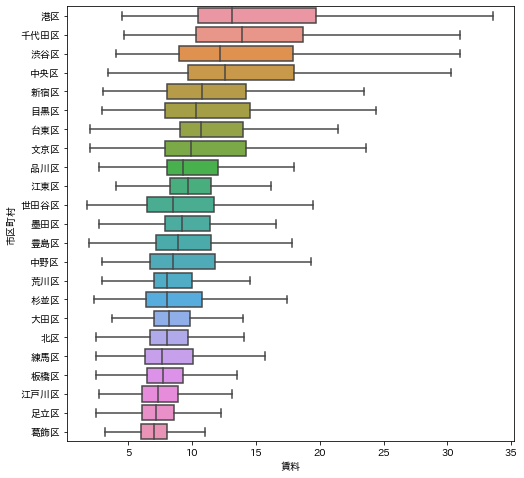

In [10]:
# 市区町村による賃料の違い
# 見づらいので外れ値は除去
# 幅が広くお高めな物件が結構ある：[千代田区、中央区、渋谷区、港区]
# 幅狭めで安め[葛飾区、足立区、板橋区、北区、練馬区、江戸川区]
order = order_mean('市区町村', '賃料','mean', False)
plt.figure(figsize=(8,8))
sns.boxplot(data=suumo, x='賃料', y='市区町村', order=order, sym='')
plt.show()

In [476]:
order_table = suumo.groupby('市区町村', as_index=False).mean()[['市区町村','賃料']].sort_values('賃料')

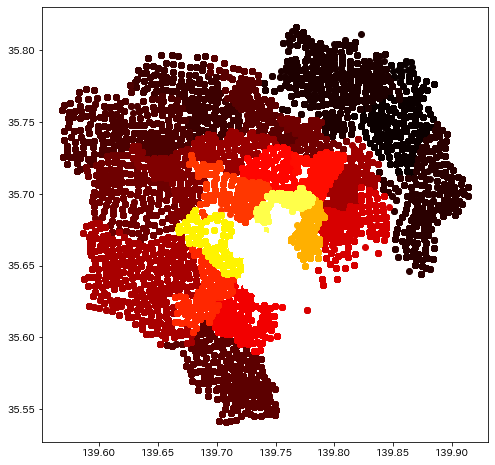

In [495]:
# 賃料平均の優劣で色分け
order_table = suumo.groupby('市区町村', as_index=False).mean()[['市区町村','賃料']].sort_values('賃料')

max_ = order_table['賃料'].max()
min_ = order_table['賃料'].min()
scale = max_ - min_

plt.figure(figsize=(8,8))
for ku, rent in order_table.values:
    condition = suumo['市区町村'] == ku
    plt.scatter(suumo.loc[condition,'経度'],suumo.loc[condition,'緯度'], color=cm.hot((rent - min_)/scale))

plt.savefig('./data/image/ku_rent.png')
plt.show()

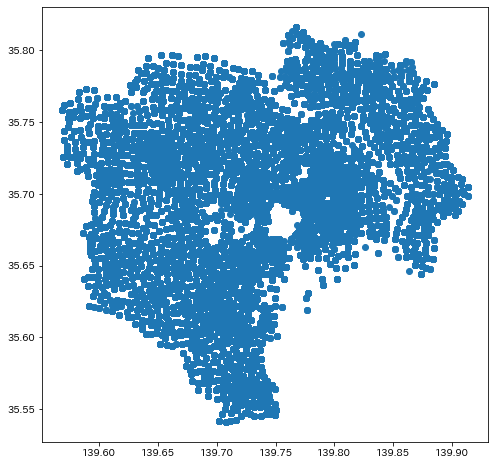

In [500]:
plt.figure(figsize=(8,8))
plt.scatter(suumo['経度'],suumo['緯度'])
plt.savefig('./data/image/23ku.png')
plt.show()

## 路線

In [93]:
# 路線情報はこちらから
url = 'https://www.navitime.co.jp/railroad'

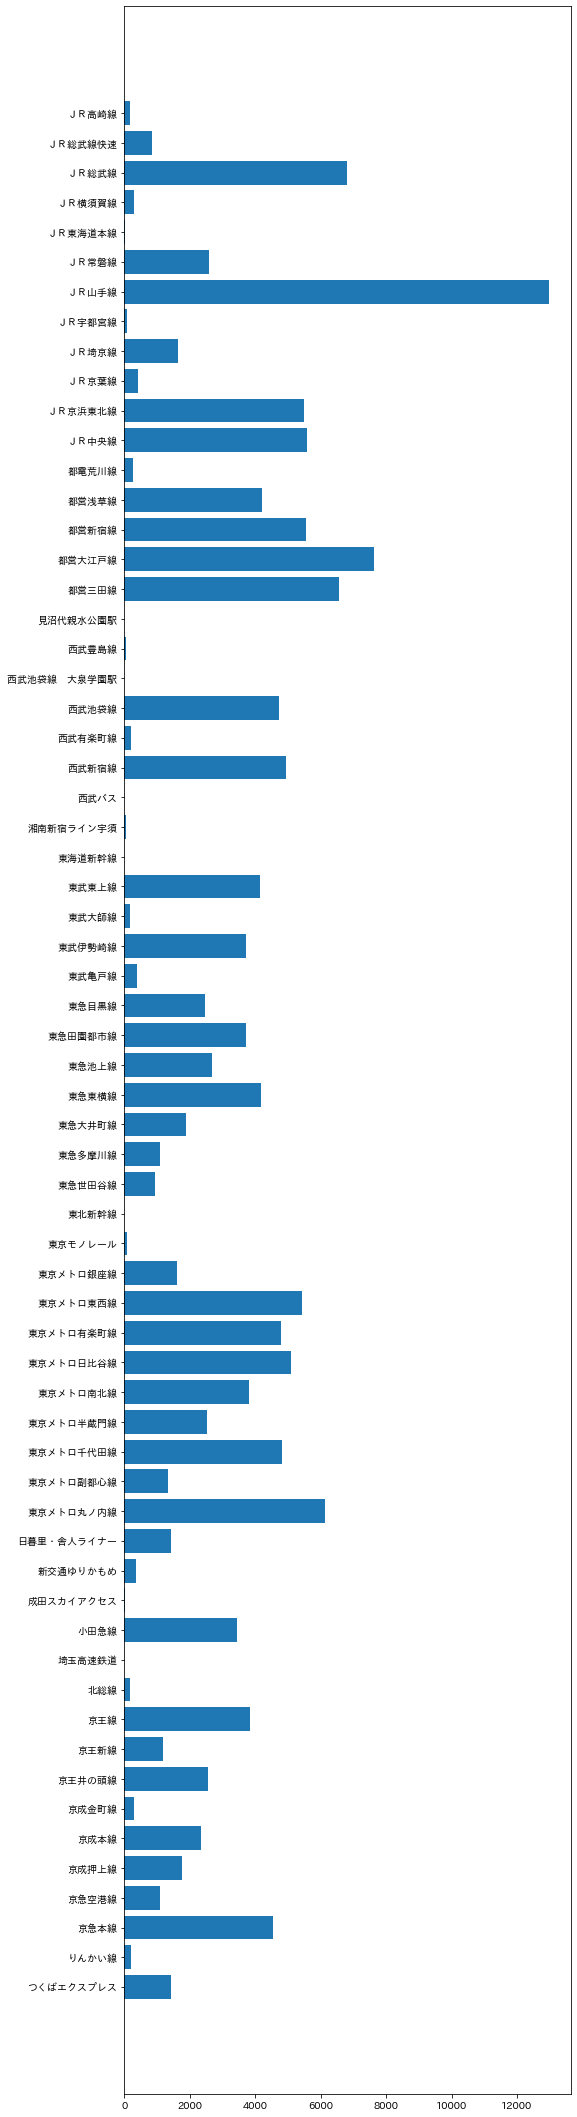

In [142]:
# 母数が少ない路線もちらほら
feature = '路線'

height = suumo[feature].unique().shape[0] * (3 / 5)
width = 8
counts = suumo.groupby(feature, as_index=False).count()[[feature,'建物名']]
plt.figure(figsize=(8,height))
plt.barh(counts[feature],counts['建物名'])
plt.show()

In [279]:
# 少ない奴はマジで少ない
feature = '路線'
counts = suumo.groupby(feature, as_index=False).count()[[feature,'建物名']]
counts.rename(columns = {'建物名':'count'}, inplace=True)
counts['ratio'] = counts['count'] / suumo.shape[0]
counts.sort_values('count')[:20]

路線  count     ratio
40         西武バス      1  0.000006
44  西武池袋線　大泉学園駅      1  0.000006
46     見沼代親水公園駅      1  0.000006
26        東北新幹線      2  0.000013
11       埼玉高速鉄道      6  0.000038
38       東海道新幹線      8  0.000051
59      ＪＲ東海道本線     31  0.000198
13    成田スカイアクセス     33  0.000210
45        西武豊島線     41  0.000261
39    湘南新宿ライン宇須     51  0.000325
56       ＪＲ宇都宮線     80  0.000510
25      東京モノレール     83  0.000529
36        東武大師線    166  0.001058
10          北総線    176  0.001121
63        ＪＲ高崎線    183  0.001166
1         りんかい線    201  0.001281
42       西武有楽町線    212  0.001351
51        都電荒川線    277  0.001765
6         京成金町線    287  0.001829
60       ＪＲ横須賀線    292  0.001861

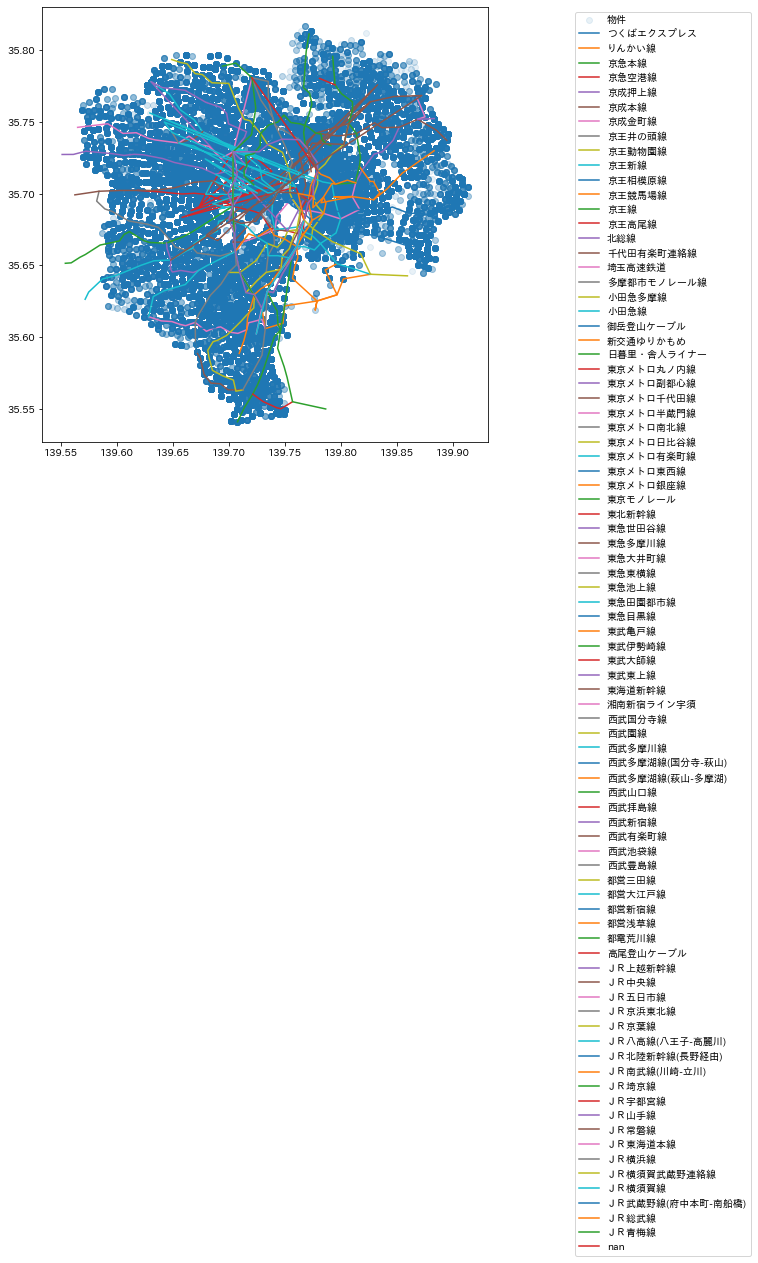

In [163]:
# 路線図
# バグってるやつがいるから直してね

plt.figure(figsize=(8,8))
plt.scatter(suumo['経度'],suumo['緯度'], alpha=0.1)

lines_all = station_all['路線'].unique()
for line in lines_all:
    condition = (station_all['路線'] == line) & (station_all['経度'] >= 139.55)
    plt.plot(
        station_all[condition].sort_values('駅番号')['経度'],
        station_all[condition].sort_values('駅番号')['緯度']
    )
plt.legend(np.r_[['物件'],lines_all], bbox_to_anchor=(1.6,1), loc='upper right')
plt.show()

In [164]:
# 賃料順に並び替え
order = suumo.groupby('路線').describe()['賃料'].sort_values('mean',ascending=False).index

In [122]:
order.sort_values().tolist()

['つくばエクスプレス',
 'りんかい線',
 '京急本線',
 '京急空港線',
 '京成押上線',
 '京成本線',
 '京成金町線',
 '京王井の頭線',
 '京王新線',
 '京王線',
 '北総線',
 '埼玉高速鉄道',
 '小田急線',
 '成田スカイアクセス',
 '新交通ゆりかもめ',
 '日暮里・舎人ライナー',
 '東京メトロ丸ノ内線',
 '東京メトロ副都心線',
 '東京メトロ千代田線',
 '東京メトロ半蔵門線',
 '東京メトロ南北線',
 '東京メトロ日比谷線',
 '東京メトロ有楽町線',
 '東京メトロ東西線',
 '東京メトロ銀座線',
 '東京モノレール',
 '東北新幹線',
 '東急世田谷線',
 '東急多摩川線',
 '東急大井町線',
 '東急東横線',
 '東急池上線',
 '東急田園都市線',
 '東急目黒線',
 '東武亀戸線',
 '東武伊勢崎線',
 '東武大師線',
 '東武東上線',
 '東海道新幹線',
 '湘南新宿ライン宇須',
 '西武バス',
 '西武新宿線',
 '西武有楽町線',
 '西武池袋線',
 '西武池袋線\u3000大泉学園駅',
 '西武豊島線',
 '見沼代親水公園駅',
 '都営三田線',
 '都営大江戸線',
 '都営新宿線',
 '都営浅草線',
 '都電荒川線',
 'ＪＲ中央線',
 'ＪＲ京浜東北線',
 'ＪＲ京葉線',
 'ＪＲ埼京線',
 'ＪＲ宇都宮線',
 'ＪＲ山手線',
 'ＪＲ常磐線',
 'ＪＲ東海道本線',
 'ＪＲ横須賀線',
 'ＪＲ総武線',
 'ＪＲ総武線快速',
 'ＪＲ高崎線']

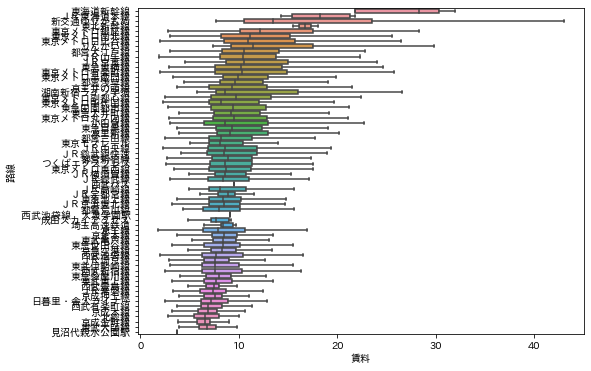

In [142]:
# 路線ごとの賃料
# 結構差があるような印象
order = order_mean('路線', '賃料','mean', False)
plt.figure(figsize=(8,6))
sns.boxplot(data=suumo, x='賃料', y='路線', order=order, sym='')
plt.show()

## 駅

In [285]:
# 少ない奴はマジで少ない
feature = '駅'
counts = suumo.groupby(feature, as_index=False).count()[[feature,'建物名']]
counts.rename(columns = {'建物名':'count'}, inplace=True)
counts['ratio'] = counts['count'] / suumo.shape[0]
counts.sort_values('count')[:50]

駅  count     ratio
383     荒川二丁目駅      1  0.000006
74        伊興赤山      1  0.000006
55      井の頭公園駅      1  0.000006
20      上野御徒町駅      1  0.000006
146   大泉学園町４丁目      1  0.000006
148     大泉風致地区      1  0.000006
308        浦安駅      1  0.000006
386    荒川遊園地前駅      1  0.000006
278        梶原駅      2  0.000013
154      学習院下駅      2  0.000013
324      王子駅前駅      2  0.000013
4    テレコムセンター駅      3  0.000019
236       有楽町駅      3  0.000019
217       新豊洲駅      3  0.000019
116       和光市駅      4  0.000025
115        向原駅      4  0.000025
235        有明駅      4  0.000025
135      大塚駅前駅      4  0.000025
19      上野広小路駅      4  0.000025
270        栄町駅      5  0.000032
400    西ケ原四丁目駅      5  0.000032
458       飛鳥山駅      5  0.000032
133    大井競馬場前駅      5  0.000032
88        内幸町駅      5  0.000032
170        山下駅      5  0.000032
124     国際展示場駅      6  0.000038
6        三ノ輪橋駅      6  0.000038
440    都電雑司ケ谷駅      6  0.000038
333      町屋駅前駅      6  0.000038
384    荒川区役所前駅      6  0.000038
158       宮ノ前駅      7  0.000045
414      西武新宿駅      7  0.000045
382     荒川七丁目駅      7  0.000045
331     町屋二丁目駅      8  0.000051
321        狛江駅      8  0.000051
180       庚申塚駅      9  0.000057
257    東池袋四丁目駅      9  0.000057
355        竹芝駅     10  0.000064
252    東尾久三丁目駅     12  0.000076
443     銀座一丁目駅     12  0.000076
381     荒川一中前駅     12  0.000076
123     国立競技場駅     12  0.000076
315    滝野川一丁目駅     12  0.000076
64         京橋駅     13  0.000083
62       京成関屋駅     13  0.000083
152       天空橋駅     14  0.000089
128        堀切駅     14  0.000089
457       面影橋駅     15  0.000096
314      溜池山王駅     15  0.000096
385     荒川車庫前駅     15  0.000096

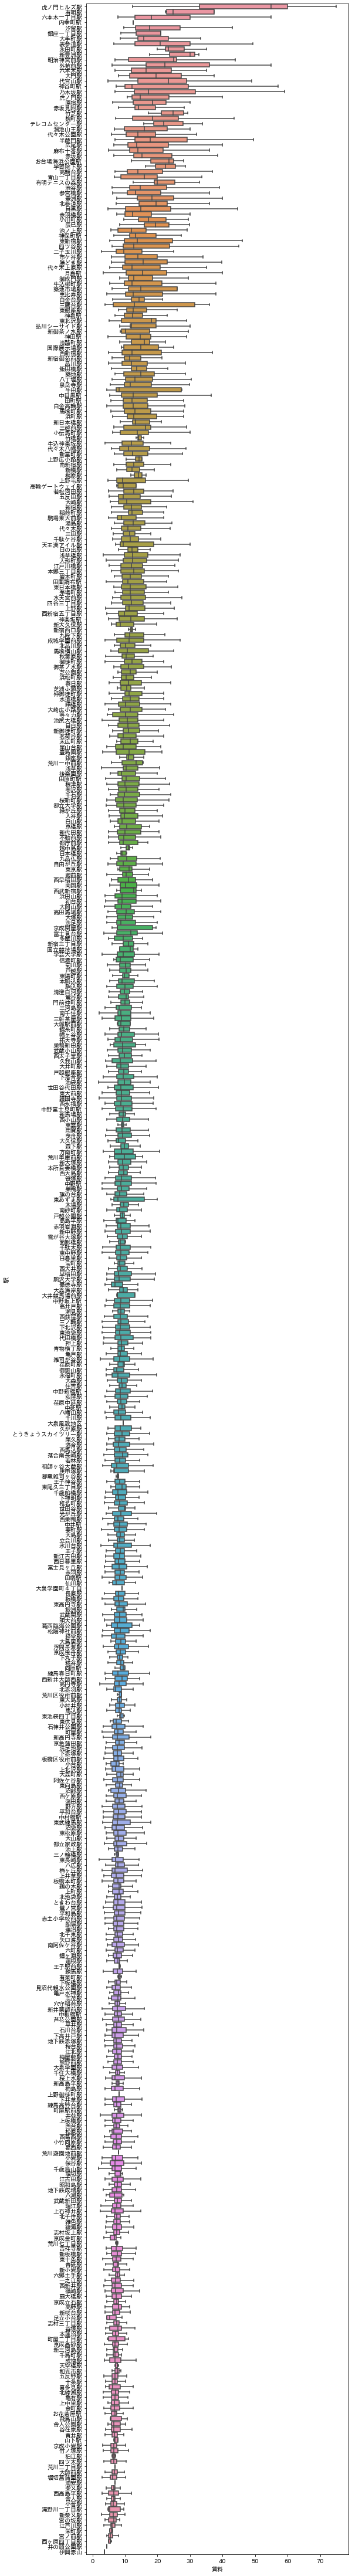

In [60]:
# 駅と賃料
order = order_mean('駅', '賃料','mean', False)
plt.figure(figsize=(8,80))
sns.boxplot(data=suumo, x='賃料', y='駅',order=order, sym='')
plt.show()

In [25]:
order_station = order_mean('駅','賃料','mean',True)

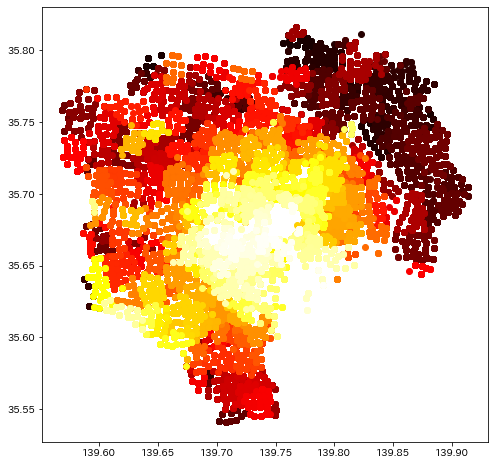

In [26]:
plt.figure(figsize=(8,8))
for id, station in enumerate(order_station):
    plt.scatter(suumo.loc[suumo['駅']==station,'経度'],suumo.loc[suumo['駅']==station,'緯度'],color=cm.hot(id/(len(order_station)+1)), alpha=1)
plt.show()

## 歩

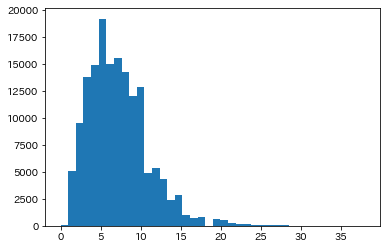

In [226]:
feature = '歩'
plt.hist(suumo[feature], bins=40)
plt.show()

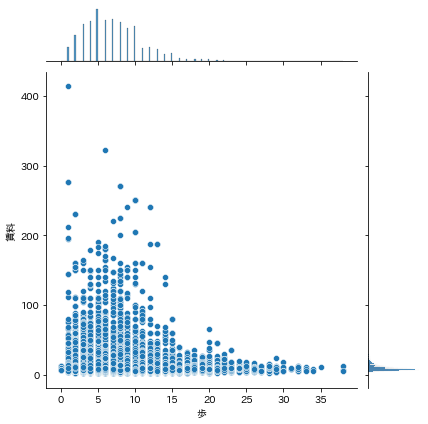

In [47]:
feature = '歩'
sns.jointplot(data=suumo, x=feature, y='賃料')
plt.show()

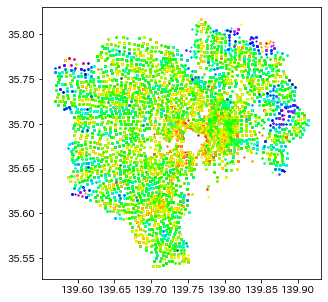

In [46]:
feature = '歩'
order = sorted(suumo[feature].unique())
max_ = suumo[feature].max()
min_ = suumo[feature].min()
scale = max_ - min_

plt.figure(figsize=(5,5))
for value in order:
    condition = suumo[feature] == value
    plt.scatter(suumo.loc[condition,'経度'],suumo.loc[condition,'緯度'], color=cm.hsv((value-min)/scale), s=1)
plt.show()

## バス

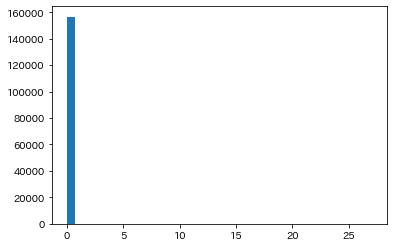

In [227]:
# このグラフに意味はない
feature = 'バス'
plt.hist(suumo[feature], bins=40)
plt.show()

328 件


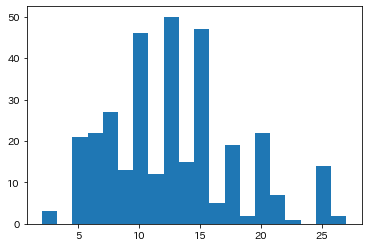

In [237]:
# 0以外だと…
feature = 'バス'
condition = suumo[feature] != 0
print(suumo.loc[condition,feature].count(),'件')
plt.hist(suumo.loc[condition,feature], bins=20)
plt.show()

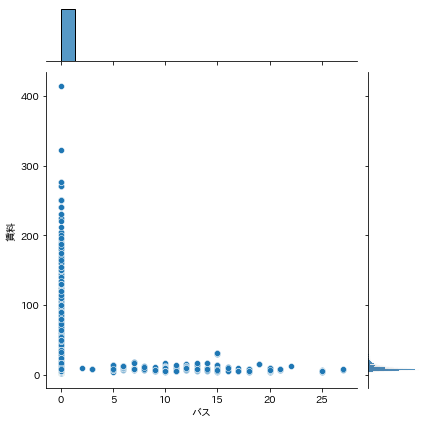

In [48]:
feature = 'バス'
sns.jointplot(data=suumo, x=feature, y='賃料')
plt.show()

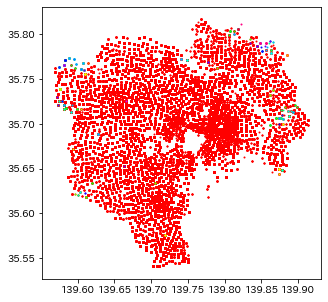

In [49]:
feature = 'バス'
order = sorted(suumo[feature].unique())
max_ = suumo[feature].max()
min_ = suumo[feature].min()
scale = max_ - min_

plt.figure(figsize=(5,5))
for value in order:
    condition = suumo[feature] == value
    plt.scatter(suumo.loc[condition,'経度'],suumo.loc[condition,'緯度'], color=cm.hsv((value-min)/scale), s=1)
plt.show()

## 車

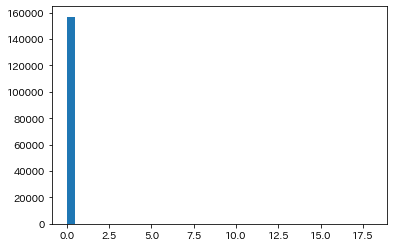

In [239]:
# このグラフに意味はない
feature = '車'
plt.hist(suumo[feature], bins=40)
plt.show()

29 件


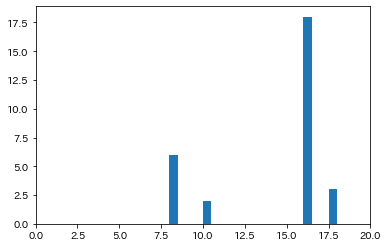

In [240]:
# 0以外だと…
feature = '車'
condition = suumo[feature] != 0
print(suumo.loc[condition,feature].count(),'件')
plt.hist(suumo.loc[condition,feature], bins=20)
plt.xlim(0,20)
plt.show()

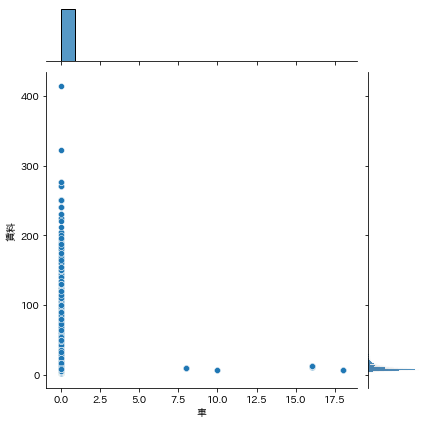

In [50]:
feature = '車'
sns.jointplot(data=suumo, x=feature, y='賃料')
plt.show()

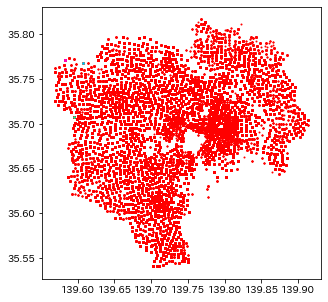

In [51]:
feature = '車'
order = sorted(suumo[feature].unique())
max_ = suumo[feature].max()
min_ = suumo[feature].min()
scale = max_ - min_

plt.figure(figsize=(5,5))
for value in order:
    condition = suumo[feature] == value
    plt.scatter(suumo.loc[condition,'経度'],suumo.loc[condition,'緯度'], color=cm.hsv((value-min)/scale), s=1)
plt.show()

## 築年数

In [294]:
condition = suumo['築年数'] >= 70
suumo[condition].sort_values('築年数', ascending=False)['url'].tolist()

['https://suumo.jp/chintai/jnc_000045284628/?bc=100277541656',
 'https://suumo.jp/chintai/jnc_000077313016/?bc=100299776055',
 'https://suumo.jp/chintai/jnc_000077283508/?bc=100299630935',
 'https://suumo.jp/chintai/jnc_000076075657/?bc=100291567232',
 'https://suumo.jp/chintai/jnc_000075063346/?bc=100281380486',
 'https://suumo.jp/chintai/jnc_000077060614/?bc=100298477680',
 'https://suumo.jp/chintai/jnc_000059894506/?bc=100300084577',
 'https://suumo.jp/chintai/jnc_000067457599/?bc=100245454989',
 'https://suumo.jp/chintai/jnc_000076803203/?bc=100297040673',
 'https://suumo.jp/chintai/jnc_000070690163/?bc=100263693213',
 'https://suumo.jp/chintai/jnc_000056525688/?bc=100297948642',
 'https://suumo.jp/chintai/jnc_000068823354/?bc=100297728722',
 'https://suumo.jp/chintai/jnc_000061581791/?bc=100297799731',
 'https://suumo.jp/chintai/jnc_000056791894/?bc=100295957660',
 'https://suumo.jp/chintai/jnc_000076585002/?bc=100294677732',
 'https://suumo.jp/chintai/jnc_000068210491/?bc=1002499

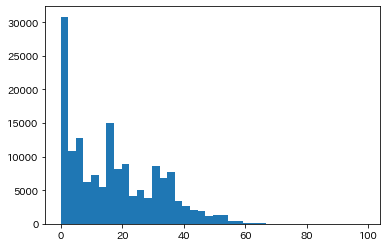

In [241]:
feature = '築年数'
plt.hist(suumo[feature], bins=40)
plt.show()

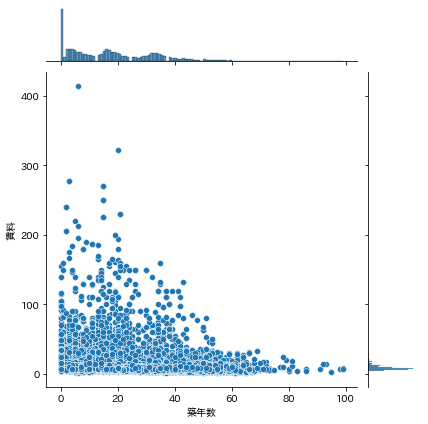

In [53]:
feature = '築年数'
sns.jointplot(data=suumo, x=feature, y='賃料')
plt.show()

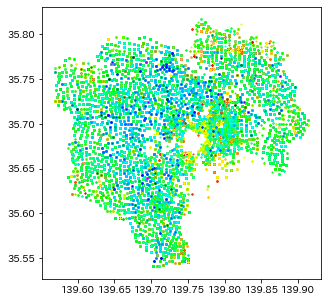

In [62]:
feature = '築年数'
order = sorted(suumo[feature].unique())
max_ = suumo[feature].max()
min_ = suumo[feature].min()
scale = max_ - min_

plt.figure(figsize=(5,5))
for value in order:
    condition = suumo[feature] == value
    plt.scatter(suumo.loc[condition,'経度'],suumo.loc[condition,'緯度'], color=cm.hsv((value-min)/scale), s=1)
plt.show()

## 地上

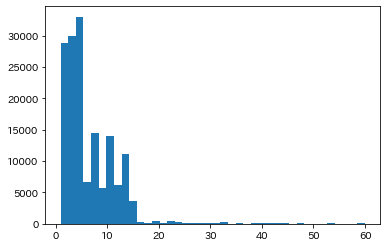

In [242]:
feature = '地上'
plt.hist(suumo[feature], bins=40)
plt.show()

In [249]:
# 16階から極端に数が減るらしいよ
suumo.groupby('地上').count()['建物名']

地上
1        75
2     28746
3     29938
4     17025
5     15989
6      6601
7      7840
8      6584
9      5676
10     7653
11     6314
12     6126
13     4755
14     6386
15     3606
16      240
17      118
18      180
19      205
20      174
21      106
22      304
23      105
24      325
25      129
26       64
27       62
28       44
29       69
30      156
31       48
32      194
33       61
34       23
35       29
36       32
37       46
38       41
39       94
40      144
41       35
42       30
43       75
44       69
45       34
46        4
47       24
48       74
49       36
50        5
52       36
53       27
54       31
55       20
56       40
58       47
60       49
Name: 建物名, dtype: int64

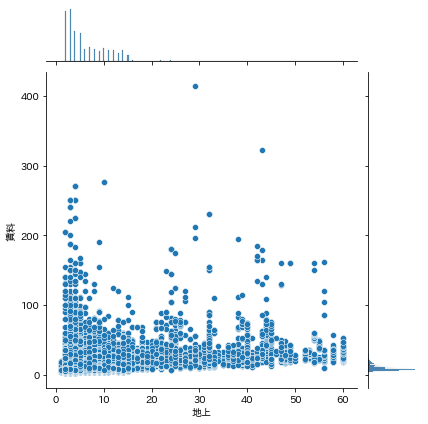

In [64]:
feature = '地上'
sns.jointplot(data=suumo, x=feature, y='賃料')
plt.show()

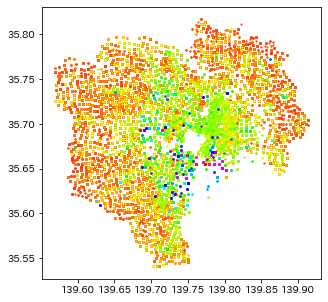

In [63]:
feature = '地上'
order = sorted(suumo[feature].unique())
max_ = suumo[feature].max()
min_ = suumo[feature].min()
scale = max_ - min_

plt.figure(figsize=(5,5))
for value in order:
    condition = suumo[feature] == value
    plt.scatter(suumo.loc[condition,'経度'],suumo.loc[condition,'緯度'], color=cm.hsv((value-min)/scale), s=1)
plt.show()

## 地下

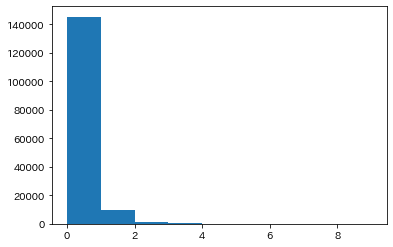

In [308]:
feature = '地下'
plt.hist(suumo[feature], bins=9)
plt.show()

11510 件


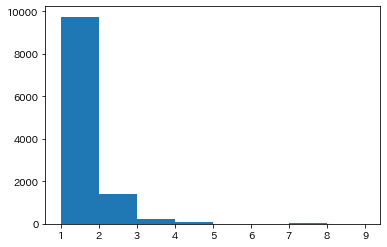

In [316]:
# 0以外だと…
feature = '地下'
condition = suumo[feature] != 0
print(suumo.loc[condition,feature].count(),'件')
plt.hist(suumo.loc[condition,feature], bins=8)
plt.show()

In [319]:
feature = '地下'
condition = suumo[feature] == 9
suumo[condition]

カテゴリ        建物名          経度         緯度 都道府県 市区町村 市区町村以下  \
74159  賃貸マンション  エムフラット秋葉原  139.778442  35.703251  東京都  台東区    台東２   

           皇居からの距離      経度(区)      緯度(区)  ... 地下  階数    階   賃料    管理費   敷金  \
74159  3098.488219  139.77977  35.712452  ...  9  19  9.0  9.5  10000  9.5   

        礼金  間取り   専有面積                                                url  
74159  9.5   1K  25.21  https://suumo.jp/chintai/jnc_000070623232/?bc=...  

[1 rows x 30 columns]

In [456]:
# 地下9階はあっているらしいよ
suumo.loc[74159,'url']

'https://suumo.jp/chintai/jnc_000070623232/?bc=100295636352'

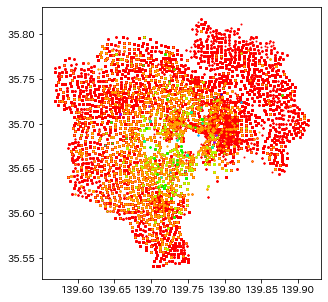

In [66]:
feature = '地下'
order = sorted(suumo[feature].unique())
max_ = suumo[feature].max()
min_ = suumo[feature].min()
scale = max_ - min_

plt.figure(figsize=(5,5))
for value in order:
    condition = suumo[feature] == value
    plt.scatter(suumo.loc[condition,'経度'],suumo.loc[condition,'緯度'], color=cm.hsv((value-min)/scale), s=1)
plt.show()

## 階数

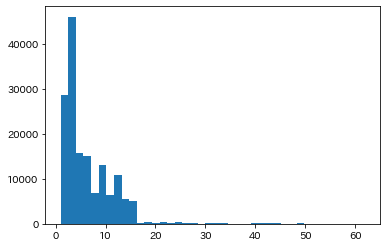

In [245]:
feature = '階数'
plt.hist(suumo[feature], bins=40)
plt.show()

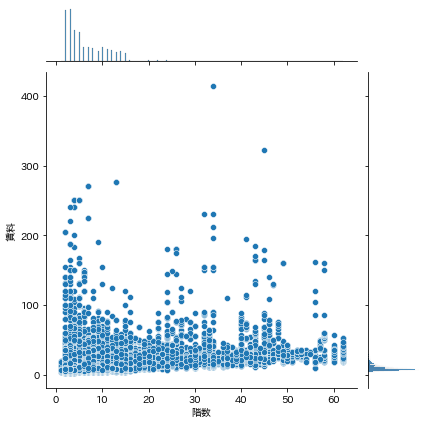

In [71]:
feature = '階数'
sns.jointplot(data=suumo, x=feature, y='賃料')
plt.show()

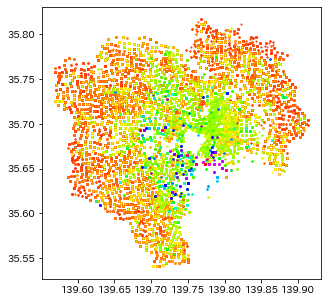

In [72]:
feature = '階数'
order = sorted(suumo[feature].unique())
max_ = suumo[feature].max()
min_ = suumo[feature].min()
scale = max_ - min_

plt.figure(figsize=(5,5))
for value in order:
    condition = suumo[feature] == value
    plt.scatter(suumo.loc[condition,'経度'],suumo.loc[condition,'緯度'], color=cm.hsv((value-min)/scale), s=1)
plt.show()

## 階

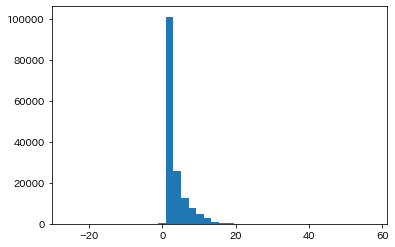

In [250]:
feature = '階'
plt.hist(suumo[feature], bins=40)
plt.show()

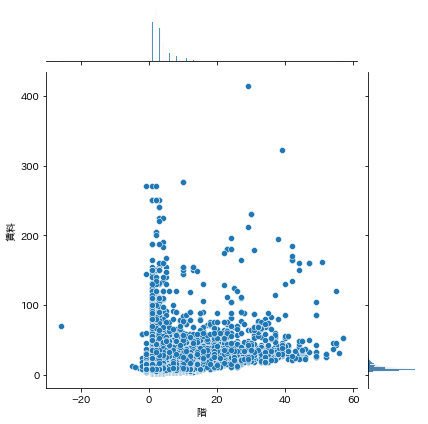

In [69]:
feature = '階'
sns.jointplot(data=suumo, x=feature, y='賃料')
plt.show()

In [257]:
# 地下26階の物件は削除されていました
condition = suumo['階'] <= -20
suumo.loc[condition,'url'].values

array(['https://suumo.jp/chintai/jnc_000026289591/?bc=100299244460'],
      dtype=object)

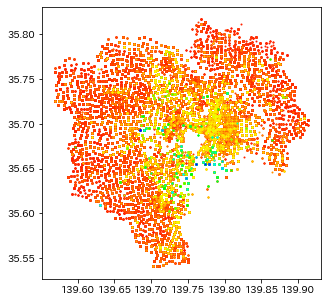

In [70]:
feature = '階'
order = sorted(suumo[feature].unique())
max_ = suumo[feature].max()
min_ = suumo[feature].min()
scale = max_ - min_

plt.figure(figsize=(5,5))
for value in order:
    condition = suumo[feature] == value
    plt.scatter(suumo.loc[condition,'経度'],suumo.loc[condition,'緯度'], color=cm.hsv((value-min)/scale), s=1)
plt.show()

## 賃料

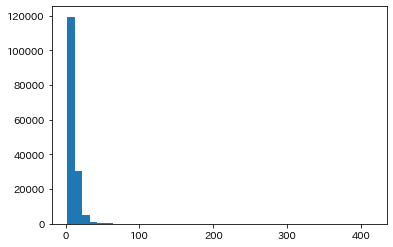

In [460]:
# 賃貸だしバカ高い物件のほうが少ないよね…
feature = '賃料'
plt.hist(suumo[feature], bins=40)
plt.show()

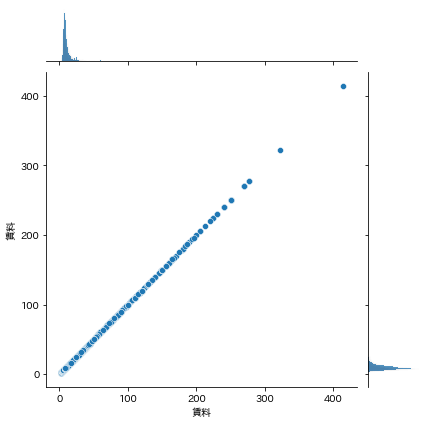

In [73]:
feature = '賃料'
sns.jointplot(data=suumo, x=feature, y='賃料')
plt.show()

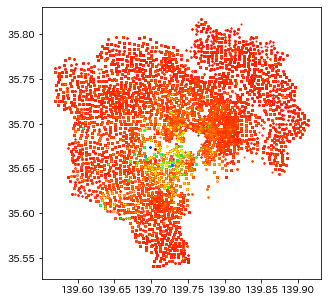

In [74]:
feature = '賃料'
order = sorted(suumo[feature].unique())
max_ = suumo[feature].max()
min_ = suumo[feature].min()
scale = max_ - min_

plt.figure(figsize=(5,5))
for value in order:
    condition = suumo[feature] == value
    plt.scatter(suumo.loc[condition,'経度'],suumo.loc[condition,'緯度'], color=cm.hsv((value-min)/scale), s=1)
plt.show()

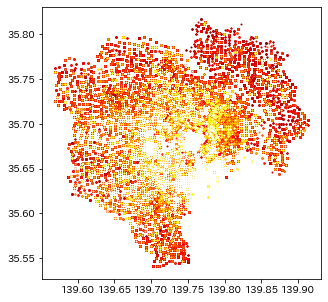

In [79]:
feature = '賃料'
order = sorted(suumo[feature].unique())
max_ = 30
min_ = suumo[feature].min()
scale = max_ - min_

plt.figure(figsize=(5,5))
for value in order:
    condition = (suumo[feature] == value) & (suumo[feature] <= 30 )
    plt.scatter(suumo.loc[condition,'経度'],suumo.loc[condition,'緯度'], color=cm.hot((value-min)/scale), s=1)
plt.show()

## 管理費

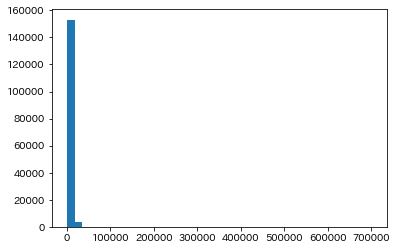

In [461]:
# 管理費ってだいたい5000円らしいよ
feature = '管理費'
plt.hist(suumo[feature], bins=40)
plt.show()

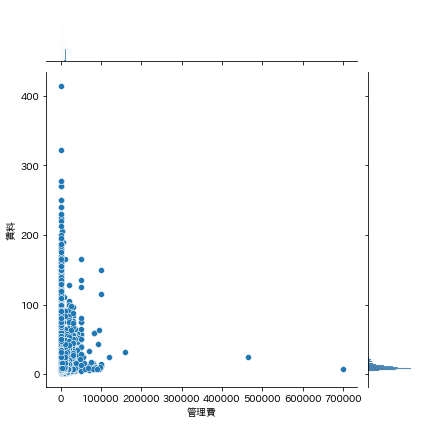

In [75]:
feature = '管理費'
sns.jointplot(data=suumo, x=feature, y='賃料')
plt.show()

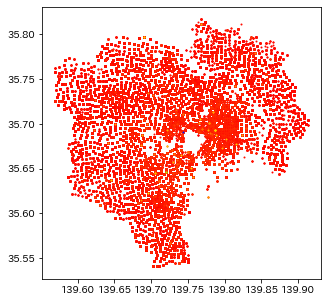

In [81]:
feature = '管理費'
order = sorted(suumo[feature].unique())
max_ = suumo[feature].max()
min_ = suumo[feature].min()
scale = max_ - min_

plt.figure(figsize=(5,5))
for value in order:
    condition = suumo[feature] == value
    plt.scatter(suumo.loc[condition,'経度'],suumo.loc[condition,'緯度'], color=cm.hsv((value-min)/scale), s=1)
plt.show()

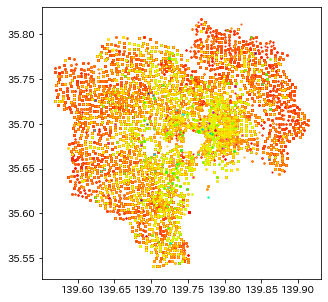

In [94]:
feature = '管理費'
order = sorted(suumo[feature].unique())
max_ = 100000
min_ = suumo[feature].min()
scale = max_ - min_

plt.figure(figsize=(5,5))
for value in order:
    condition = (suumo[feature] == value) & (suumo['賃料'] <= 30 )
    plt.scatter(suumo.loc[condition,'経度'],suumo.loc[condition,'緯度'], color=cm.hsv((value-min)/scale), s=1)
plt.show()

## 敷金

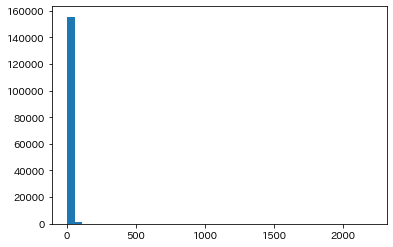

In [462]:
# 敷金ってだいたい家賃の2倍とかだよね
feature = '敷金'
plt.hist(suumo[feature], bins=40)
plt.show()

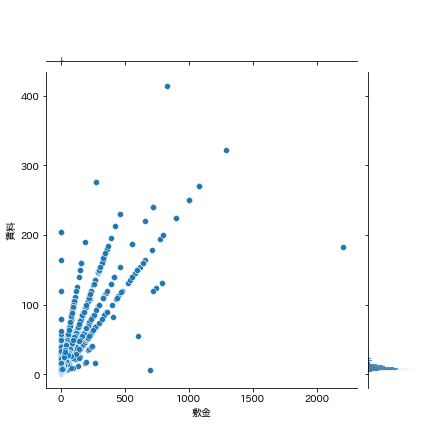

In [463]:
# 敷金ってだいたい家賃の2倍とかだよね
feature = '敷金'
sns.jointplot(data=suumo, x=feature, y='賃料')
plt.show()

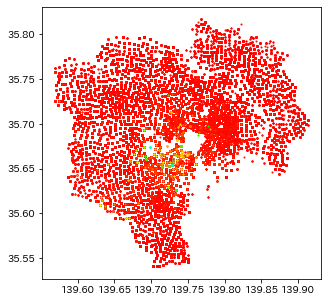

In [86]:
feature = '敷金'
order = sorted(suumo[feature].unique())
max_ = suumo[feature].max()
min_ = suumo[feature].min()
scale = max_ - min_

plt.figure(figsize=(5,5))
for value in order:
    condition = suumo[feature] == value
    plt.scatter(suumo.loc[condition,'経度'],suumo.loc[condition,'緯度'], color=cm.hsv((value-min)/scale), s=1)
plt.show()

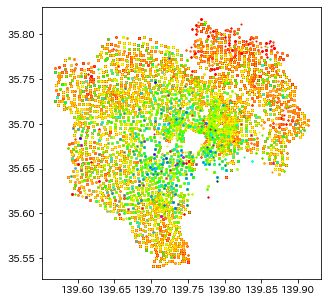

In [95]:
feature = '敷金'
order = sorted(suumo[feature].unique())
max_ = 100
min_ = suumo[feature].min()
scale = max_ - min_

plt.figure(figsize=(5,5))
for value in order:
    condition = (suumo[feature] == value) & (suumo['賃料'] <= 30 )
    plt.scatter(suumo.loc[condition,'経度'],suumo.loc[condition,'緯度'], color=cm.hsv((value-min)/scale), s=1)
plt.show()

## 礼金

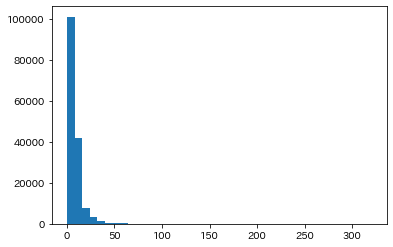

In [465]:
# 礼金ってだいたい家賃の2倍とかだよね
feature = '礼金'
plt.hist(suumo[feature], bins=40)
plt.show()

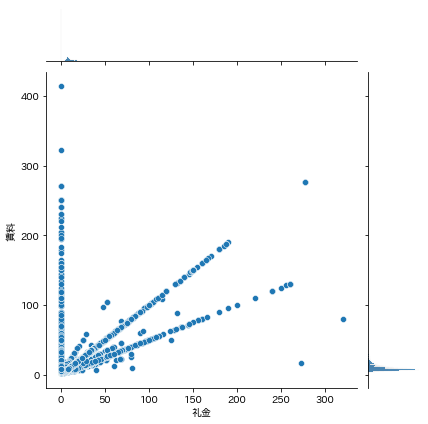

In [87]:
# 礼金とかいう謎制度を考えた守銭奴は誰
feature = '礼金'
sns.jointplot(data=suumo, x=feature, y='賃料')
plt.show()

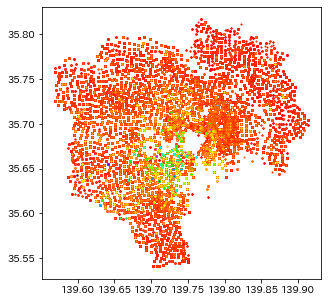

In [89]:
feature = '礼金'
order = sorted(suumo[feature].unique())
max_ = suumo[feature].max()
min_ = suumo[feature].min()
scale = max_ - min_

plt.figure(figsize=(5,5))
for value in order:
    condition = suumo[feature] == value
    plt.scatter(suumo.loc[condition,'経度'],suumo.loc[condition,'緯度'], color=cm.hsv((value-min)/scale), s=1)
plt.show()

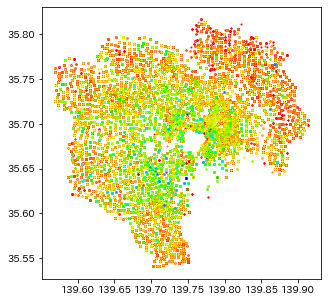

In [96]:
feature = '礼金'
order = sorted(suumo[feature].unique())
max_ = 100
min_ = suumo[feature].min()
scale = max_ - min_

plt.figure(figsize=(5,5))
for value in order:
    condition = (suumo[feature] == value) & (suumo['賃料'] <= 30 )
    plt.scatter(suumo.loc[condition,'経度'],suumo.loc[condition,'緯度'], color=cm.hsv((value-min)/scale), s=1)
plt.show()

## 専有面積

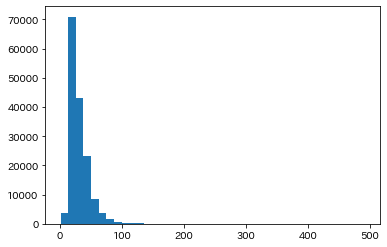

In [467]:
# 専有面積100もあったら凄いよね。
feature = '専有面積'
plt.hist(suumo[feature], bins=40)
plt.show()

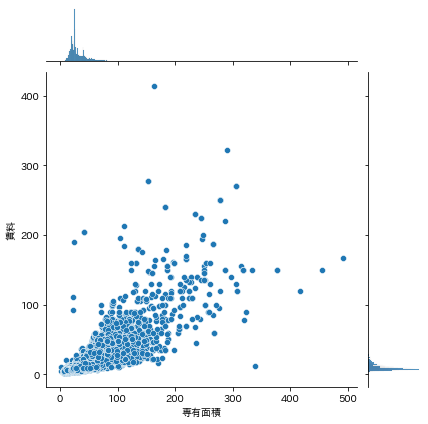

In [464]:
# 対数変換したほうがいいのかしら？
feature = '専有面積'
sns.jointplot(data=suumo, x=feature, y='賃料')
plt.show()

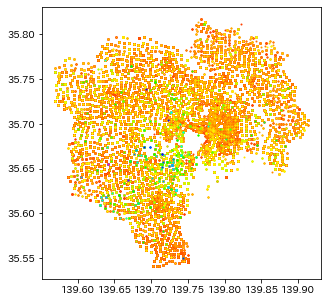

In [92]:
feature = '専有面積'
order = sorted(suumo[feature].unique())
max_ = suumo[feature].max()
min_ = suumo[feature].min()
scale = max_ - min_

plt.figure(figsize=(5,5))
for value in order:
    condition = suumo[feature] == value
    plt.scatter(suumo.loc[condition,'経度'],suumo.loc[condition,'緯度'], color=cm.hsv((value-min)/scale), s=1)
plt.show()

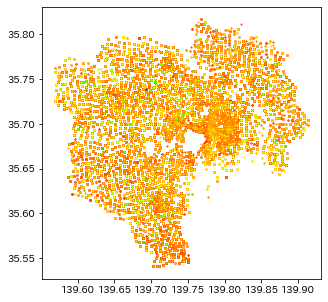

In [98]:
feature = '専有面積'
order = sorted(suumo[feature].unique())
max_ = suumo[feature].max()
min_ = suumo[feature].min()
scale = max_ - min_

plt.figure(figsize=(5,5))
for value in order:
    condition = (suumo[feature] == value) & (suumo['賃料'] <= 30 )
    plt.scatter(suumo.loc[condition,'経度'],suumo.loc[condition,'緯度'], color=cm.hsv((value-min)/scale), s=1)
plt.show()

## 間取り

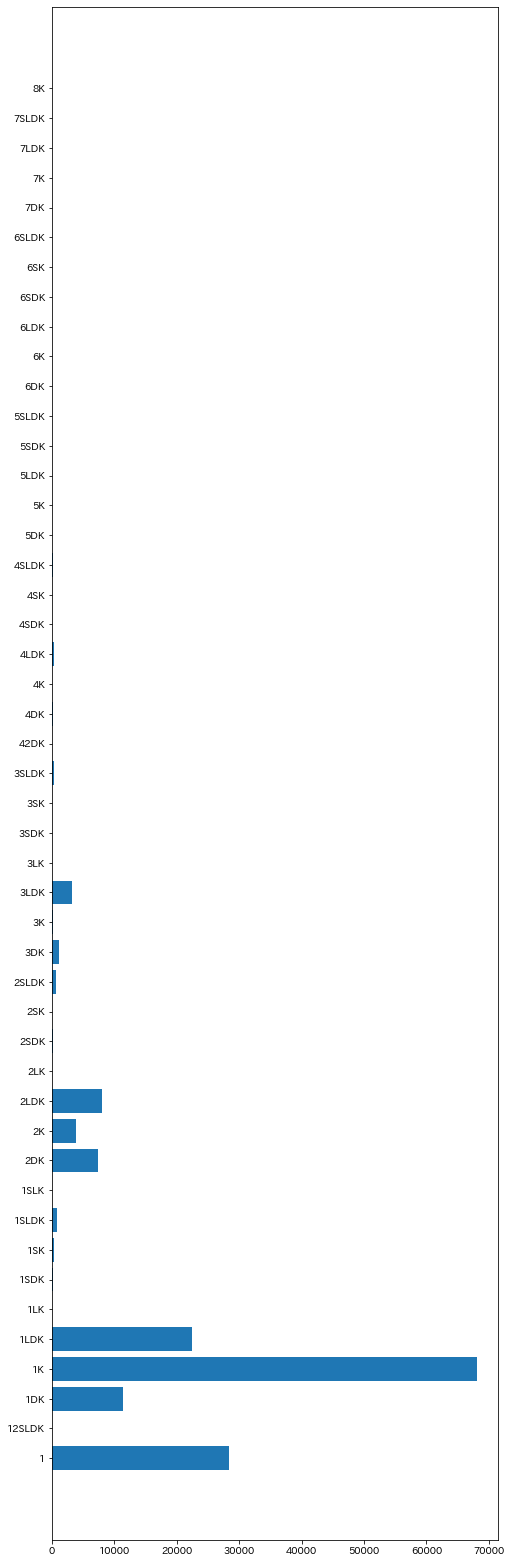

In [322]:
# 母数が少ない間取りも結構ある
feature = '間取り'

height = suumo[feature].unique().shape[0] * (3 / 5)
width = 8
counts = suumo.groupby(feature, as_index=False).count()[[feature,'建物名']]
plt.figure(figsize=(8,height))
plt.barh(counts[feature],counts['建物名'])
plt.show()

In [323]:
# 少ない奴はマジで少ない
feature = '間取り'
suumo.groupby(feature, as_index=False).count()[[feature,'建物名']]
counts.sort_values('建物名')[:50]

間取り    建物名
46      8K      1
37      6K      1
24    42DK      1
39    6SDK      1
20     3LK      1
40     6SK      1
43      7K      1
1   12SLDK      1
29     4SK      1
34    5SDK      1
42     7DK      2
28    4SDK      3
41   6SLDK      5
13     2LK      5
45   7SLDK      5
22     3SK      7
9     1SLK      8
44    7LDK      9
36     6DK     10
15     2SK     14
5      1LK     16
32      5K     21
21    3SDK     24
35   5SLDK     26
31     5DK     28
38    6LDK     28
26      4K     41
33    5LDK     43
30   4SLDK     78
14    2SDK     79
25     4DK     86
6     1SDK    119
18      3K    215
23   3SLDK    229
7      1SK    295
27    4LDK    362
16   2SLDK    627
8    1SLDK    799
17     3DK   1156
19    3LDK   3126
11      2K   3791
10     2DK   7345
12    2LDK   8045
2      1DK  11417
4     1LDK  22453
0        1  28280
3       1K  68136

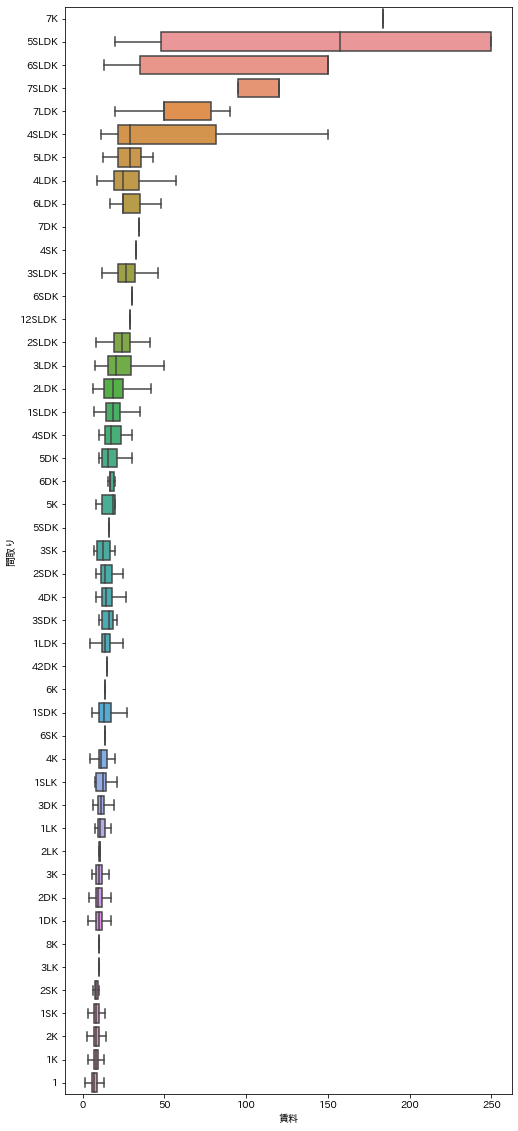

In [433]:
# 間取りと賃料
feature = '間取り'
order = order_mean(feature, '賃料','mean', False)
plt.figure(figsize=(8,20))
sns.boxplot(data=suumo, x='賃料', y=feature, order=order, sym='')
plt.show()

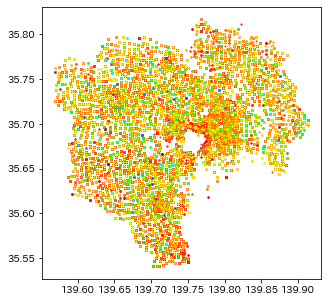

In [112]:
feature = '間取り'
order = order_mean(feature, '賃料','count', False)

plt.figure(figsize=(5,5))
for num, value in enumerate(order):
    condition = suumo[feature] == value
    plt.scatter(suumo.loc[condition,'経度'],suumo.loc[condition,'緯度'], color=cm.hsv((num)/len(order)), s=1)
plt.show()

## 部屋数

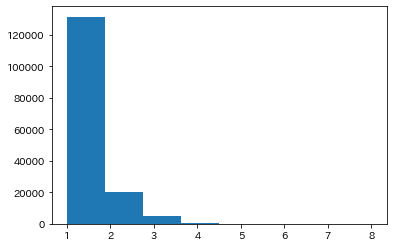

In [337]:
# 賃貸だし3部屋もあればクソ広いよね
condition = suumo['部屋数'] <= 10
plt.hist(suumo.loc[condition,'部屋数'], bins=8)
plt.show()

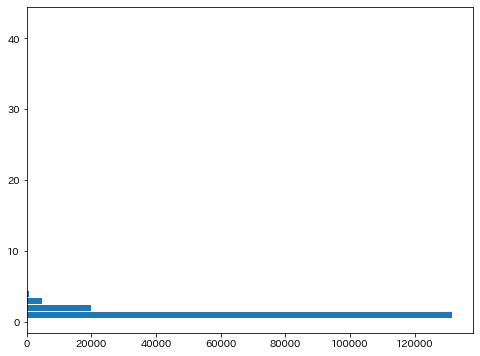

In [339]:
# 母数が少ない間取りも結構ある
feature = '部屋数'

height = suumo[feature].unique().shape[0] * (3 / 5)
width = 8
counts = suumo.groupby(feature, as_index=False).count()[[feature,'建物名']]
plt.figure(figsize=(8,height))
plt.barh(counts[feature],counts['建物名'])
plt.show()

In [340]:
# 少ない奴はマジで少ない
feature = '部屋数'
suumo.groupby(feature, as_index=False).count()[[feature,'建物名']]
counts.sort_values('建物名')[:50]

部屋数     建物名
7    8       1
8   12       1
9   42       1
6    7      17
5    6      46
4    5     119
3    4     571
2    3    4758
1    2   19906
0    1  131523

In [395]:
# 順番調整
def order_mean(group, by, index, asc):
    sort_describe = suumo.groupby(group).describe()[by].sort_values(index,ascending=asc)
    order = sort_describe.index
    return order

In [417]:
table = copy.copy(suumo)
table['部屋数'] = table['部屋数'].astype(str)

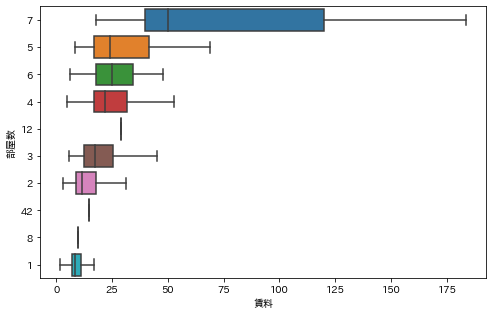

In [446]:
# 部屋数と賃料
feature = '部屋数'
table = copy.copy(suumo)
table['部屋数'] = table['部屋数'].astype(str)
order = order_mean('部屋数','賃料','mean',False)
order = order.astype(str)
plt.figure(figsize=(8,5))
sns.boxplot(data=table, x='賃料', y='部屋数', order=order, sym='')
plt.show()

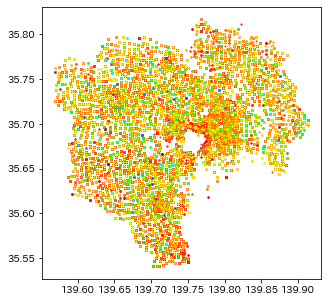

In [112]:
feature = '間取り'
order = order_mean(feature, '賃料','count', False)

plt.figure(figsize=(5,5))
for num, value in enumerate(order):
    condition = suumo[feature] == value
    plt.scatter(suumo.loc[condition,'経度'],suumo.loc[condition,'緯度'], color=cm.hsv((num)/len(order)), s=1)
plt.show()

## S,L,D,K

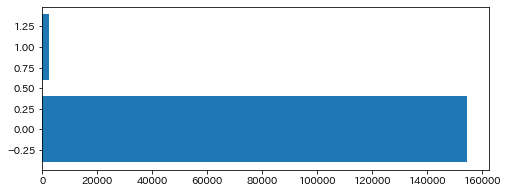

In [447]:
# Sがついている物件は少ない
alpha = 'S'
table = suumo.groupby(f'間取り_{alpha}', as_index=False).count()[[f'間取り_{alpha}', '建物名']]
plt.figure(figsize=(8,3))
plt.barh(table[f'間取り_{alpha}'].values,table['建物名'].values)
plt.show()

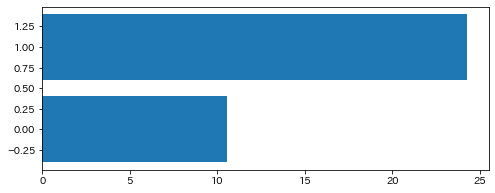

In [448]:
# Sがついていると賃料が上がるっぽい
alpha = 'S'
table = suumo.groupby(f'間取り_{alpha}', as_index=False).mean()[[f'間取り_{alpha}','賃料']]
plt.figure(figsize=(8,3))
plt.barh(table[f'間取り_{alpha}'].values,table['賃料'].values)
plt.show()

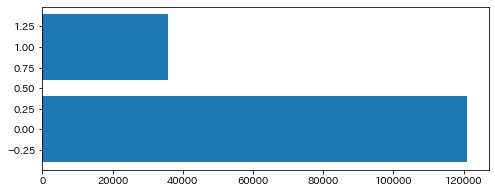

In [449]:
# Lがついている物件は少ない
alpha = 'L'
table = suumo.groupby(f'間取り_{alpha}', as_index=False).count()[[f'間取り_{alpha}', '建物名']]
plt.figure(figsize=(8,3))
plt.barh(table[f'間取り_{alpha}'].values,table['建物名'].values)
plt.show()

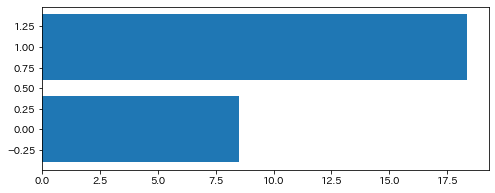

In [450]:
# Lがついていると賃料が上がるっぽい
alpha = 'L'
table = suumo.groupby(f'間取り_{alpha}', as_index=False).mean()[[f'間取り_{alpha}','賃料']]
plt.figure(figsize=(8,3))
plt.barh(table[f'間取り_{alpha}'].values,table['賃料'].values)
plt.show()

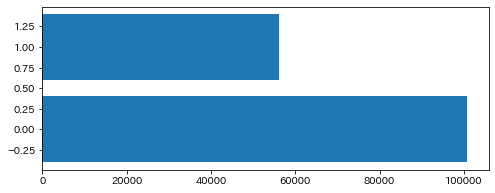

In [451]:
# Dがついている物件は結構ある
alpha = 'D'
table = suumo.groupby(f'間取り_{alpha}', as_index=False).count()[[f'間取り_{alpha}', '建物名']]
plt.figure(figsize=(8,3))
plt.barh(table[f'間取り_{alpha}'].values,table['建物名'].values)
plt.show()

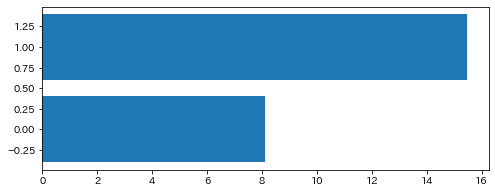

In [452]:
# Dがついていると賃料が上がるっぽい
alpha = 'D'
table = suumo.groupby(f'間取り_{alpha}', as_index=False).mean()[[f'間取り_{alpha}','賃料']]
plt.figure(figsize=(8,3))
plt.barh(table[f'間取り_{alpha}'].values,table['賃料'].values)
plt.show()

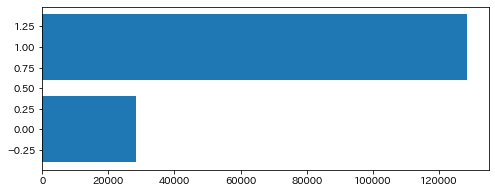

In [453]:
# Kがついていない＝ワンルームです。
# ワンルームじゃない方が高いのはそらそうなのよ
alpha = 'K'
table = suumo.groupby(f'間取り_{alpha}', as_index=False).count()[[f'間取り_{alpha}', '建物名']]
plt.figure(figsize=(8,3))
plt.barh(table[f'間取り_{alpha}'].values,table['建物名'].values)
plt.show()

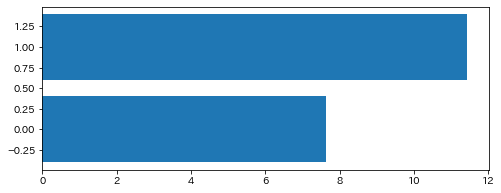

In [454]:
# Kがついていると賃料が上がるっぽい（そらそう）
alpha = 'K'
table = suumo.groupby(f'間取り_{alpha}', as_index=False).mean()[[f'間取り_{alpha}','賃料']]
plt.figure(figsize=(8,3))
plt.barh(table[f'間取り_{alpha}'].values,table['賃料'].values)
plt.show()

## 最寄り駅からの距離

In [15]:
# 最寄駅からの距離[m]
suumo['最寄駅からの距離'] = 0
condition = ~suumo['経度(駅)'].isnull()
suumo.loc[condition,'最寄駅からの距離'] = suumo[condition].apply(lambda x: distance(x['経度'], x['緯度'], x['経度(駅)'], x['緯度(駅)']), axis=1)

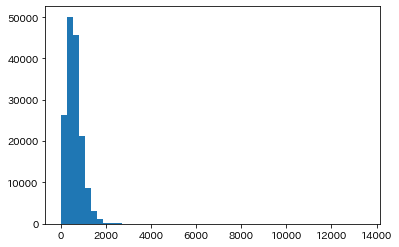

In [212]:
# 最寄り駅が遠すぎる殿方は何なの？
# ものによっては本当に遠い。ものによってはsuumoくんの設定がおかしい。
# 結合は間違ってなさそう。suumoくんの最寄り駅設定がおかしい。
plt.hist(suumo['最寄駅からの距離'], bins=50)
plt.show()

In [177]:
# 駅から離れすぎな皆さんは結合バグ？ => 結合は間違ってないっぽい
condition = suumo['最寄駅からの距離'] >= 3000
features = ['市区町村', '路線', '駅', '最寄駅からの距離', 'url']
suumo.loc[condition,features]

市区町村         路線       駅      最寄駅からの距離  \
33736    足立区  東京メトロ千代田線    北千住駅   3489.954355   
55076    練馬区      ＪＲ中央線    吉祥寺駅   3285.824077   
91106    足立区  東京メトロ千代田線     綾瀬駅   3003.824937   
91107    足立区  東京メトロ千代田線     綾瀬駅   3003.824937   
91108    足立区  東京メトロ千代田線     綾瀬駅   3003.824937   
91975    足立区     東武伊勢崎線    竹ノ塚駅   3245.964233   
97360    葛飾区      ＪＲ常磐線     金町駅   3204.339500   
97361    葛飾区      ＪＲ常磐線     金町駅   3204.339500   
97362    葛飾区      ＪＲ常磐線     金町駅   3204.339500   
97363    葛飾区      ＪＲ常磐線     金町駅   3204.339500   
97364    葛飾区      ＪＲ常磐線     金町駅   3204.339500   
97538    足立区     東武伊勢崎線    竹ノ塚駅   4816.232681   
97539    足立区     東武伊勢崎線    竹ノ塚駅   4816.232681   
97540    足立区     東武伊勢崎線    竹ノ塚駅   4816.232681   
114934   練馬区      東武東上線     成増駅   3028.104115   
114935   練馬区      東武東上線     成増駅   3028.104115   
117095   練馬区  東京メトロ有楽町線  地下鉄成増駅   3792.712980   
117096   練馬区  東京メトロ有楽町線  地下鉄成増駅   3792.712980   
120937   品川区        京王線    八幡山駅  13488.819840   
120938   品川区        京王線    八幡山駅  13488.819840   
122063   練馬区  東京メトロ有楽町線  地下鉄成増駅   6345.525389   
125321  世田谷区      ＪＲ山手線     渋谷駅   3965.744909   
138351   葛飾区      ＪＲ常磐線     金町駅   3204.339500   
141942   練馬区      東武東上線     成増駅   3028.104115   
141943   練馬区      東武東上線     成増駅   3028.104115   
145509   葛飾区      ＪＲ常磐線     亀有駅   3038.832595   
145510   葛飾区      ＪＲ常磐線     亀有駅   3038.832595   
146609   渋谷区   東京メトロ南北線    白金台駅   4563.823426   
148675   葛飾区      ＪＲ常磐線     金町駅   3204.339500   
152233   足立区  東京メトロ千代田線    北千住駅   3489.954355   
155464   葛飾区      ＪＲ常磐線     金町駅   3204.339500   
155465   葛飾区      ＪＲ常磐線     金町駅   3204.339500   
155466   葛飾区      ＪＲ常磐線     金町駅   3204.339500   
155467   葛飾区      ＪＲ常磐線     金町駅   3204.339500   
155468   葛飾区      ＪＲ常磐線     金町駅   3204.339500   

                                                      url  
33736   https://suumo.jp/chintai/jnc_000072360796/?bc=...  
55076   https://suumo.jp/chintai/jnc_000019000267/?bc=...  
91106   https://suumo.jp/chintai/jnc_000076956292/?bc=...  
91107   https://suumo.jp/chintai/jnc_000076956293/?bc=...  
91108   https://suumo.jp/chintai/jnc_000076717064/?bc=...  
91975   https://suumo.jp/chintai/jnc_000076230633/?bc=...  
97360   https://suumo.jp/chintai/jnc_000077114082/?bc=...  
97361   https://suumo.jp/chintai/jnc_000077114087/?bc=...  
97362   https://suumo.jp/chintai/jnc_000077114086/?bc=...  
97363   https://suumo.jp/chintai/jnc_000077114085/?bc=...  
97364   https://suumo.jp/chintai/jnc_000077114084/?bc=...  
97538   https://suumo.jp/chintai/jnc_000076654642/?bc=...  
97539   https://suumo.jp/chintai/jnc_000076896568/?bc=...  
97540   https://suumo.jp/chintai/jnc_000076647667/?bc=...  
114934  https://suumo.jp/chintai/jnc_000076475492/?bc=...  
114935  https://suumo.jp/chintai/jnc_000076475493/?bc=...  
117095  https://suumo.jp/chintai/jnc_000076170349/?bc=...  
117096  https://suumo.jp/chintai/jnc_000076170348/?bc=...  
120937  https://suumo.jp/chintai/jnc_000063597242/?bc=...  
120938  https://suumo.jp/chintai/jnc_000057777560/?bc=...  
122063  https://suumo.jp/chintai/jnc_000077340119/?bc=...  
125321  https://suumo.jp/chintai/jnc_000044585823/?bc=...  
138351  https://suumo.jp/chintai/jnc_000075729284/?bc=...  
141942  https://suumo.jp/chintai/jnc_000076353606/?bc=...  
141943  https://suumo.jp/chintai/jnc_000076823155/?bc=...  
145509  https://suumo.jp/chintai/jnc_000076533950/?bc=...  
145510  https://suumo.jp/chintai/jnc_000076533951/?bc=...  
146609  https://suumo.jp/chintai/jnc_000057093360/?bc=...  
148675  https://suumo.jp/chintai/jnc_000077258154/?bc=...  
152233  https://suumo.jp/chintai/jnc_000072360798/?bc=...  
155464  https://suumo.jp/chintai/jnc_000077114094/?bc=...  
155465  https://suumo.jp/chintai/jnc_000077114093/?bc=...  
155466  https://suumo.jp/chintai/jnc_000077114096/?bc=...  
155467  https://suumo.jp/chintai/jnc_000077114097/?bc=...  
155468  https://suumo.jp/chintai/jnc_000077114095/?bc=...

歩      6
バス    20
車      0
Name: 91107, dtype: object


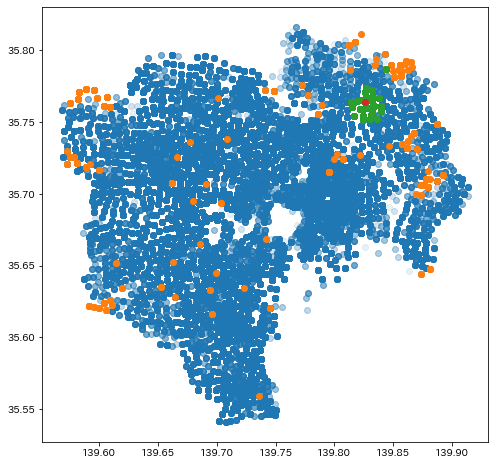

In [469]:
# ほぼ外にいるやつはわかる。都心にいるやつは何？
# 綾瀬のバグは物件が遠すぎ（バグじゃない）で間違いないっぽい

print(suumo.loc[91107,['歩','バス','車']])

plt.figure(figsize=(8,8))
plt.scatter(suumo['経度'],suumo['緯度'], alpha=0.1)

condition = suumo['最寄駅からの距離'] >= 2000
plt.scatter(suumo.loc[condition,'経度'],suumo.loc[condition,'緯度'])

condition = suumo['駅'] == '綾瀬駅'
plt.scatter(suumo.loc[condition,'経度'],suumo.loc[condition,'緯度'])

condition = station_coordinates['駅'] == '綾瀬'
plt.scatter(station_coordinates.loc[condition,'経度'],station_coordinates.loc[condition,'緯度'])

plt.show()

歩      3
バス    20
車      0
Name: 97360, dtype: object


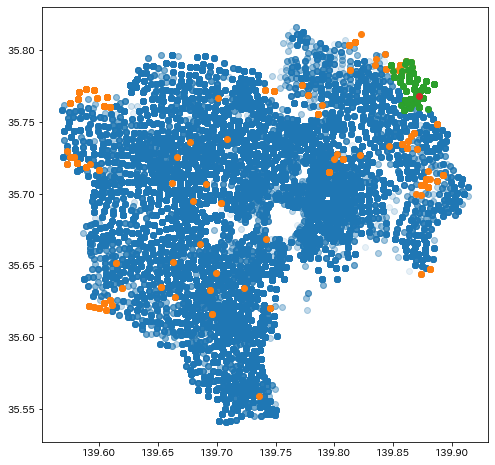

In [205]:
# ほぼ外にいるやつはわかる。都心にいるやつは何？
# 金町のバグは物件が遠すぎ（バグじゃない）で分からなくはなかった

print(suumo.loc[97360,['歩','バス','車']])

plt.figure(figsize=(8,8))
plt.scatter(suumo['経度'],suumo['緯度'], alpha=0.1)

condition = suumo['最寄駅からの距離'] >= 2000
plt.scatter(suumo.loc[condition,'経度'],suumo.loc[condition,'緯度'])

condition = suumo['駅'] == '金町駅'
plt.scatter(suumo.loc[condition,'経度'],suumo.loc[condition,'緯度'])

condition = station_coordinates['駅'] == '金町'
plt.scatter(station_coordinates.loc[condition,'経度'],station_coordinates.loc[condition,'緯度'])

plt.show()

歩      0
バス     0
車     18
Name: 97538, dtype: object


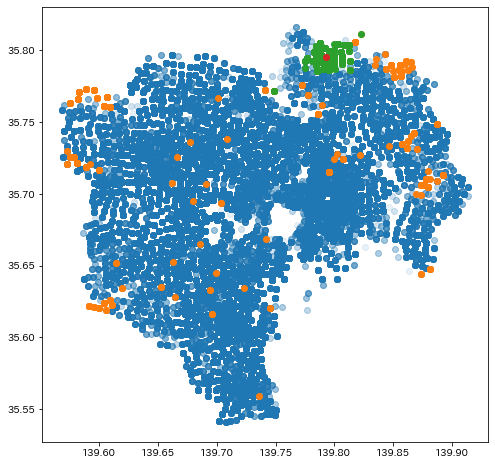

In [204]:
# ほぼ外にいるやつはわかる。都心にいるやつは何？
# 竹ノ塚のバグは物件が遠すぎ（バグじゃない）で分からなくはなかった

print(suumo.loc[97538,['歩','バス','車']])

plt.figure(figsize=(8,8))
plt.scatter(suumo['経度'],suumo['緯度'], alpha=0.1)

condition = suumo['最寄駅からの距離'] >= 2000
plt.scatter(suumo.loc[condition,'経度'],suumo.loc[condition,'緯度'])

condition = suumo['駅'] == '竹ノ塚駅'
plt.scatter(suumo.loc[condition,'経度'],suumo.loc[condition,'緯度'])

condition = station_coordinates['駅'] == '竹ノ塚'
plt.scatter(station_coordinates.loc[condition,'経度'],station_coordinates.loc[condition,'緯度'])

plt.show()

歩      3
バス    14
車      0
Name: 114934, dtype: object


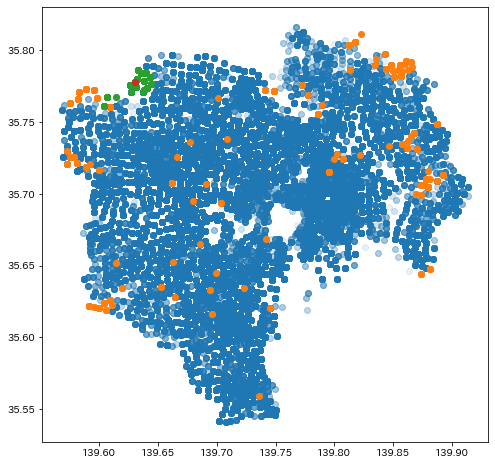

In [209]:
# ほぼ外にいるやつはわかる。都心にいるやつは何？
# 成増のバグは物件が遠すぎ（バグじゃない）で分からなくはなかった

print(suumo.loc[114934,['歩','バス','車']])

plt.figure(figsize=(8,8))
plt.scatter(suumo['経度'],suumo['緯度'], alpha=0.1)

condition = suumo['最寄駅からの距離'] >= 2000
plt.scatter(suumo.loc[condition,'経度'],suumo.loc[condition,'緯度'])

condition = suumo['駅'] == '成増駅'
plt.scatter(suumo.loc[condition,'経度'],suumo.loc[condition,'緯度'])

condition = station_coordinates['駅'] == '成増'
plt.scatter(station_coordinates.loc[condition,'経度'],station_coordinates.loc[condition,'緯度'])

plt.show()

歩      2
バス    20
車      0
Name: 125321, dtype: object
https://suumo.jp/chintai/jnc_000044585823/?bc=100300077469


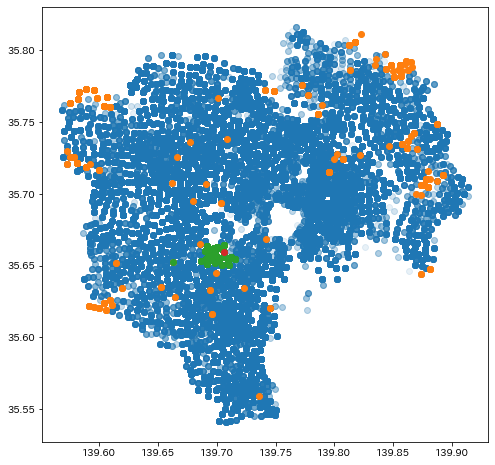

In [211]:
# ほぼ外にいるやつはわかる。都心にいるやつは何？
# 渋谷のバグは物件が遠すぎ（バグじゃない）で分からなくはなかった
# なんで最寄り駅渋谷にしたんですかね…

print(suumo.loc[125321,['歩','バス','車']])
print(suumo.loc[125321,'url'])

plt.figure(figsize=(8,8))
plt.scatter(suumo['経度'],suumo['緯度'], alpha=0.1)

condition = suumo['最寄駅からの距離'] >= 2000
plt.scatter(suumo.loc[condition,'経度'],suumo.loc[condition,'緯度'])

condition = suumo['駅'] == '渋谷駅'
plt.scatter(suumo.loc[condition,'経度'],suumo.loc[condition,'緯度'])

condition = station_coordinates['駅'] == '渋谷'
plt.scatter(station_coordinates.loc[condition,'経度'],station_coordinates.loc[condition,'緯度'])

plt.show()

歩     6
バス    0
車     0
Name: 120937, dtype: object
https://suumo.jp/chintai/jnc_000063597242/?bc=100299202785


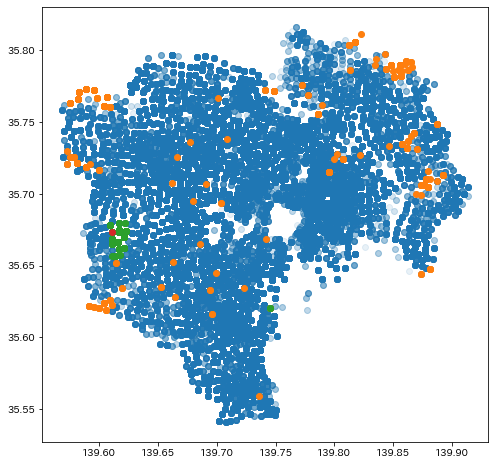

In [470]:
# ほぼ外にいるやつはわかる。都心にいるやつは何？
# 八幡山のバグはたぶん本当にバグ => バグじゃなかった。最寄り駅が絶対に八幡山じゃないゾ

print(suumo.loc[120937,['歩','バス','車']])
print(suumo.loc[120937,'url'])

plt.figure(figsize=(8,8))
plt.scatter(suumo['経度'],suumo['緯度'], alpha=0.1)

condition = suumo['最寄駅からの距離'] >= 2000
plt.scatter(suumo.loc[condition,'経度'],suumo.loc[condition,'緯度'])

condition = suumo['駅'] == '八幡山駅'
plt.scatter(suumo.loc[condition,'経度'],suumo.loc[condition,'緯度'])

condition = station_coordinates['駅'] == '八幡山'
plt.scatter(station_coordinates.loc[condition,'経度'],station_coordinates.loc[condition,'緯度'])

plt.show()

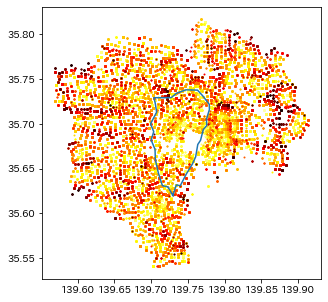

In [517]:
feature = '最寄駅からの距離'
order = sorted(suumo[feature].unique())
max_ = 2000
min_ = 0
scale = max_ - min_

plt.figure(figsize=(5,5))
for value in order:
    condition = (suumo[feature] == value) & (suumo[feature] <= max_)
    plt.scatter(suumo.loc[condition,'経度'],suumo.loc[condition,'緯度'], color=cm.hot(1-((value-min_)/scale)), s=1)
    
condition = station_all['路線'] == 'ＪＲ山手線'
plt.plot(station_all.loc[condition,'経度'],station_all.loc[condition,'緯度'])
plt.savefig('./data/image/distance_nearest_station.png')
plt.show()

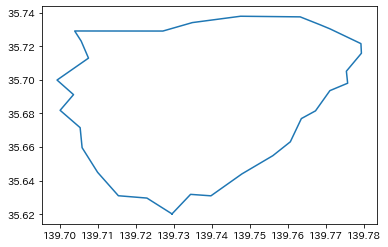

In [515]:
condition = station_all['路線'] == 'ＪＲ山手線'
plt.plot(station_all.loc[condition,'経度'],station_all.loc[condition,'緯度'])
plt.show()

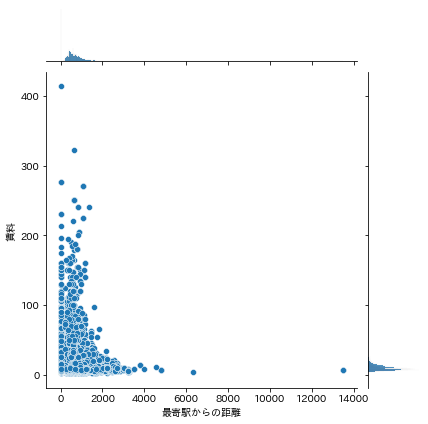

In [217]:
feature = '最寄駅からの距離'
sns.jointplot(data=suumo, x=feature, y='賃料')
plt.show()

## 皇居からの距離

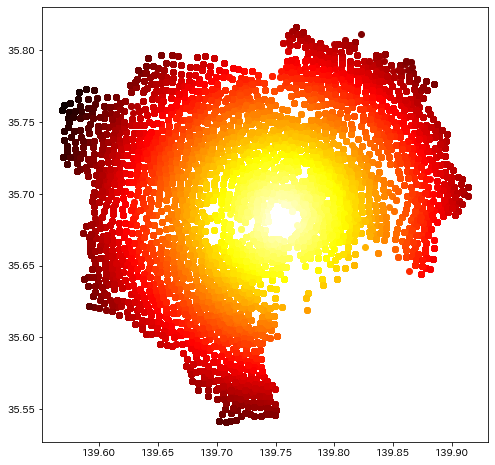

In [503]:
# 皇居からの距離
plt.figure(figsize=(8,8))
max = suumo['皇居からの距離'].max()

for value in suumo['皇居からの距離'].unique():
    condition = suumo['皇居からの距離'] == value
    plt.scatter(suumo.loc[condition,'経度'],suumo.loc[condition,'緯度'],color=cm.hot(1-(value/max)))

plt.savefig('./data/image/distance_koukyo.png')
plt.show()

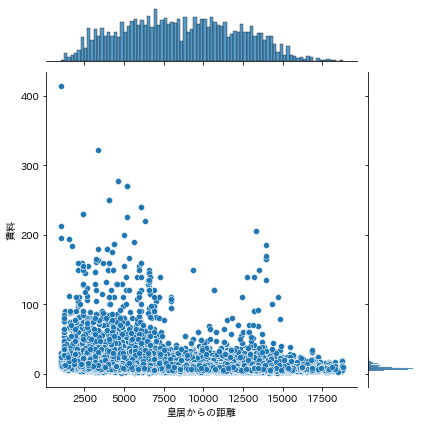

In [220]:
feature = '皇居からの距離'
sns.jointplot(data=suumo, x=feature, y='賃料')
plt.show()